# Introdução

Nesse trabalho iremos criar um model de aprendizado de máquina para prever quanto views e likes um vídeo do nicho de bodybuilding brasileiro terá no YouTube, dado informações que são disponíveis antes do vídeo ser publicado. 

Selecionamos um nicho por ser uma área de interesse e também por entendermos que teríamos melhores resultados de predição usando vídeos de canais de um nicho específico. Esperamos que a homogeneidade do público de um nicho aprimorará a aprendizagem do modelo.

## Os dados

Para isso, utilizaremos um dataset com quase 40k vídeos do YouTube. Esse dataset foi obtido através do uso da API do Youtube, como veremos mais a frente. Ele é composto tanto de dados tabulares quanto imagens (thumbnails) que extraímos dos vídeos.

Os nossos dados tabulares contém as seguintes colunas:

1) Video ID
2) Title
3) Thumbnail URL
4) Subscriber Count
5) Total Views    
6) Video Count
7) Views           
8) Likes     
9) Date Posted
10) Duration (Seconds)        
11) Tags       
12) Published Day of Week_Monday     
13) Published Day of Week_Friday   
14) Published Day of Week_Saturday     
15) Published Day of Week_Sunday     
16) Published Day of Week_Thursday       
17) Published Day of Week_Tuesday        
18) Published Day of Week_Wednesday
19) Published Time of Day_Afternoon
20) Published Time of Day_Early Morning
21) Published Time of Day_Evening
22) Published Time of Day_Late Afternoon
23) Published Time of Day_Late Morning
24) Published Time of Day_Midnight
25) Published Time of Day_Morning
26) Published Time of Day_Night

Veja que
- Subscriber Count, Total Views e Video Count são métricas do canal ao qual o vídeo (instância) pertence.
- Um vídeo pode ter várias tags. Depois trataremos esses dados para poderem ser usados pelo nosso modelo.
- Optamos por modelar o dado do dia da semana em que um vídeo é postado (Published Day of Week) através de um onehot encoding, como veremos mais a frente.
- Optamos por modelar o dado do horário do dia em que um vídeo é postado (Published Time of Day) através de um onehot encoding, como veremos mais a frente.

Os nossos dados em formato de imagens possuem uma resolução de 480 × 360 e como dito antes, são as thumbnails dos vídeos que estão contidos nos dados tabulares visto acima.

## O modelo

Dado a recente popularidade do GPT-4o da OpenAI que se baseia em um modelo multimodal, decidimos experimentar também com um modelo multimodal para vermos os resultados que poderíamos obter. O nosso modelo recebe dados em 3 formatos diferents:
- Imagens (que são as thumbnails dos vídeos)
- Corpos de texto:
    - Títulos dos vídeos
    - Tags dos vídeos
- Dados numéricos ou booleanos (como número de inscritos, se foi postado em certo dia da semana, etc...)

Os dados numéricos ou booleanos podem ser aceitos facilmente por qualquer modelo. Contudo, as imagens e corpos de texto precisam passar por modelos próprios que aprenderão a extrair seus features para que possa ser usado junto aos dados numéricos ou booleanos. Portanto, o nosso modelo possui duas fases distintas:
1) Fase de recebimento de dados multimodais
2) Fase de extração de features dos dados de texto e imagem em dados numéricos
      1) Extração de features dos títulos e tags feito através do modelo LSTM, que foi escolhido pelas seguintes razões:
           - LSTM é uma arquitetura de Recurrent Neural Network
           - Possui ótimo desempenho para capturar dependências sobre dados sequenciais
           - LSTMs podem lembrar e utilizar informações de etapas anteriores na sequência, tornando-os adequados para entender o contexto em dados textuais
           - As características extraídas pelos LSTMs do texto são mais informativas e contextualizadas em comparação com métodos tradicionais como bag-of-words ou TF-IDF, que não consideram a ordem das palavras
           - LSTMs têm sido amplamente utilizados e comprovadamente eficazes em várias tarefas de processamento de linguagem natural
      2) Extração de features das imagens feito através do modelo VGG16, que foi escolhido pelas seguintes razões:
           - VGG16 é uma arquitetura de Convolutional Neural Network
           - Foi pré-treinado no dataset ImageNet, permitindo uma capacidade de extração de features muito grande já 'out-of-the-box'
           - A estrutura modular do VGG16 permite que ele seja facilmente conectado a outras redes neurais (como Random Forests, que veremos mais a frente), facilitando a construção de um modelo multimodal robusto.
           - A riqueza das características pré-treinadas melhora a capacidade de generalização do modelo VGG16
           -  VGG16 oferece um bom equilíbrio entre profundidade da rede e exigências computacionais, permitindo que seja xecutado em hardware disponível sem exigir recursos excessivos
3) Fase de processamento de todos os dados por dois modelos de random forest:
      1) O primeiro modelo de random forest prediz a quantidade de views do vídeo
      2) O segundo modelo prediz a quantidade de likes do vídeo
      - OBS.: random forests foram escolhidos pois:
          - Devido à média dos resultados de várias árvores, o modelo tende a ser mais estável e menos suscetível a flutuações de variação nos dados de treinamento
          - Pode facilmente aceitar características extraídas de diferentes fontes, como as features extraídas de imagens pelo VGG16, características textuais pelos LSTMs, e dados tabulares pré-processados
          - O Random Forest fornece medidas de importância das características, o que pode ajudar a entender quais atributos (por exemplo, número de inscritos, visualizações anteriores, características das thumbnails) têm maior impacto nas previsões de views e likes.
          - Random Forests podem ser treinados de maneira eficiente mesmo em datasets grandes, como o nosso conjunto de quase 49k vídeos
          - Random Forests são robustos a outliers nos dados de entrada, o que é benéfico considerando a variabilidade e a diversidade dos dados do YouTube e os vídeos virais.

![Diagram](as.png)

# Setup

## Importando as bibliotecas necessárias

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import requests
from dotenv import load_dotenv
import isodate
from datetime import datetime
import joblib
import zipfile
from googleapiclient.discovery import build
import gdown
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

2024-07-14 12:07:38.826067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Carregando dados

### Canais que usaremos

Aqui estão os canais para os quais obtivemos os vídeos:

1) Noticias Maromba
2) Renato Cariani
3) Growth
4) Gorgonoid
5) Jorlan Vieira
6) Laércio Refundini
7) Monster Cast Cortes
8) Rafael Brandão
9) Ramon Dino
10) Toguro
11) Igor Kennedy
12) Brazil Bodybuilding News
13) Horsepower Pro
14) Integral Médica
15) Jason
16) Mansao Maromba
17) Miguel Chain
18) Giga
19) Pacho
20) Coach Rubens
21) Paulo Muzy
22) Tentente Breno
23) Leo Stronda
24) Rodrigo Góes
25) Lélis
26) Adaptogen
27) Max Titanium
28) Leando Twin
29) Maxuel Vida De Um Sonhador

Abaixo temos a lista com o ID de cada um dos canais citados acima (na mesma ordem):

In [2]:
channel_ids = [
    'UCmK5h2-a4CquS4nIxDN6j7g',
    'UCPX0gLduKAfgr-HJENa7CFw',
    'UCGfrC6R2PSMeXv4hdhONB6Q',
    'UCLfCo17TCjx7qf-JMhQioLQ',
    'UC0EPH87G38158HBGzDSSZ1Q',
    'UCd4g7oX49jtbX7rN-wclkJg',
    'UCjbknPNDsL9fd860cDInPGw',
    'UC5BW1WJ3ioahNzFUBdJ7cLQ',
    'UC7RaQvO8fqoyd62RmIg_yGA',
    'UCEI44xNfQmAukxMf1kW8d5g',
    'UCfvg8A2uKlOmC1xWnUk7tpQ',
    'UC3dM3SoKkFJI5WOfY9yOlcw',
    'UCFjBjOfOoy5c6QRWXpuuyYw',
    'UCdRhxTB5X5XoJvamINrrijQ',
    'UCOOLLUHhjJ-I6dXTQ-5cq5g',
    'UC-j9NRGq1F0xRA3MIHtV0Vg',
    'UC_CbWPl-oNvRW5Yi-7D62pA',
    'UCDZgRnMZqD1qeWqLCON8PRA',
    'UCTmAy9D7NR8sHdn3Oup1wlQ',
    'UCaZLOsun_sY6BonjwR8Zo4A',
    'UCUOsr03iLj627hJm55cmIPw',
    'UCaHQNoCGk3nMRNW6mEJ6L5Q',
    'UC6gJAnIhDn2Fy_jZfICmgSA',
    'UCU_q46MCMEu5l2QdshV0hGQ',
    'UC3wVslvR1r5lKPeh7wpoG8Q',
    'UCbgmJsnqdzu9aHTEvQGupfg',
    'UCy-R3H4s0z1HubB_uSiGsHA',
    'UCPlemwX82_QEWRDC6yYnOCg',
    'UC1241gLM1-xo_ux0B1FwKdg'
]

### Informações gerais:

Aqui vamos determinar o diretório onde serão salvo os thumbnails dos vídeos

In [3]:
thumbnails_dir = 'dir'

### Pulando os passos de pegar os dados através da API do Youtube

Aqui teremos código que te ajudará a carregar os dados do projeto mais facilmente. Se fizer isso, pode pular a execução de todas as células da seção 'Usando a API do Youtube para pegar os dados'.

Certifique-se de setar skip_load como True para possibilitar isso.

Aqui estão os dados tabulares já salvos:

In [4]:
skip_load = True

if skip_load:
    data = pd.read_pickle('video_data.pkl')

    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48989 entries, 0 to 48988
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Video ID                              48989 non-null  object 
 1   Title                                 48989 non-null  object 
 2   Thumbnail URL                         48989 non-null  object 
 3   Subscriber Count                      48989 non-null  float32
 4   Total Views                           48989 non-null  float64
 5   Video Count                           48989 non-null  float32
 6   Views                                 48989 non-null  float64
 7   Likes                                 48989 non-null  float32
 8   Date Posted                           48989 non-null  float64
 9   Duration (Seconds)                    48989 non-null  float32
 10  Tags                                  48989 non-null  object 
 11  Published Day o

Caso não queira ter o trabalho de criar um API key e carregar todas as imagens por conta própria, já disponibilizamos na raiz do projeto um arquivo .zip que contém um diretório chamado dir que contém todas as imagens. Para carregar essas imagens, basta executar o seguinte código:

In [5]:
if skip_load:
    file_id = '1ZUyK0Tto1IH5f3asfOyELswDXRXwy_jk'
    output = 'images.zip'
    download_url = f'https://drive.google.com/uc?id={file_id}'
    # Download the file
    gdown.download(download_url, output, quiet=False)

    # Define the path to the zip file and the directory to extract to
    zip_file_path = 'images.zip'
    extracted_dir_path = '.'

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents of the zip file
        zip_ref.extractall(extracted_dir_path)

Downloading...
From (original): https://drive.google.com/uc?id=1ZUyK0Tto1IH5f3asfOyELswDXRXwy_jk
From (redirected): https://drive.google.com/uc?id=1ZUyK0Tto1IH5f3asfOyELswDXRXwy_jk&confirm=t&uuid=d639e779-b71e-4965-9364-f2d1160d3b46
To: /Users/danielbarbosa/Desktop/code/test/images.zip
100%|██████████| 1.59G/1.59G [02:06<00:00, 12.6MB/s]


Aqui vamos verificar que todo vídeo que estão nos dados tabulares possuem uma imagem correspondente

In [6]:
if skip_load:
    # check that the amount of files in the images folder is the same as the amount of rows in the data
    if len(os.listdir('./dir')) != data.shape[0]:
        print('Amount of files in images folder is not the same as the amount of rows in the data')

    # check if every video that is in the data is in the images folder
    total = 0
    for video_id in data['Video ID']:
        if not os.path.exists(f'./dir/{video_id}.jpg'):
            total += 1
            print(f'{total} - Video does not exist in videos folder: {video_id}.jpg')

### Usando a API do Youtube para pegar os dados

Para pegarmos nossos dados, utilizamos a API do youtube. 

Visto que o Google impõe um limite de chamadas que podem ser feitas à API, não foi possível pegar todos os dados que precisávamos de uma só vez. Assim, foi necessário criar um sistema de 'checkpoints' de modo que, quando atingido a cota de API requests diários, salvamos os novos dados que obtivemos nesse checkpoint e juntamos com os dados do último checkpoint. Veremos isso mais em detalhes mais a frente.

Aqui criaremos alumas variáveis que usaremos durante o uso da API do youtube:

In [7]:
checkpoint_file = 'checkpoint.pkl'

load_dotenv()
API_KEY = os.getenv('API_KEY')

video_data_file = 'video_data_gen.pkl'

#### Funções auxiliares para chamada de API

Aqui criaremos algumas funções que usaremos durante o uso da API do youtube:

In [8]:
def load_checkpoint():
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            return pickle.load(f)
    return None

In [9]:
def save_checkpoint(all_videos, current_channel, next_page_token):
    with open(checkpoint_file, 'wb') as f:
        pickle.dump((all_videos, current_channel, next_page_token), f)

In [10]:
# Function to save a single thumbnail to a directory
def save_thumbnail(video_id, title, thumbnail_url, thumbnails_dir):
    try:
        img_data = requests.get(thumbnail_url).content
        with open(os.path.join(thumbnails_dir, f'{video_id}.jpg'), 'wb') as handler:
            handler.write(img_data)
    except Exception as e:
        print(f'Error saving thumbnail for {title}: {e}')

In [11]:
# Function to convert ISO 8601 duration to seconds
def isoduration_to_seconds(duration):
    try:
        duration = isodate.parse_duration(duration)
        return int(duration.total_seconds())
    except Exception as e:
        print(f'Error converting duration {duration}: {e}')
        return 0

In [12]:
# Function to extract the time of day from a timestamp and bin it into categories
def extract_time_of_day(timestamp):
    try:
        time_of_day = pd.to_datetime(timestamp).time()
        if time_of_day < datetime.strptime('03:00', '%H:%M').time():
            return 'Midnight'
        elif time_of_day < datetime.strptime('06:00', '%H:%M').time():
            return 'Early Morning'
        elif time_of_day < datetime.strptime('09:00', '%H:%M').time():
            return 'Morning'
        elif time_of_day < datetime.strptime('12:00', '%H:%M').time():
            return 'Late Morning'
        elif time_of_day < datetime.strptime('15:00', '%H:%M').time():
            return 'Afternoon'
        elif time_of_day < datetime.strptime('18:00', '%H:%M').time():
            return 'Late Afternoon'
        elif time_of_day < datetime.strptime('21:00', '%H:%M').time():
            return 'Evening'
        else:
            return 'Night'
    except Exception as e:
        print(f'Error extracting time of day from {timestamp}: {e}')
        return 'Unknown'

In [13]:
def extract_day_of_week(timestamp):
    try:
        return pd.to_datetime(timestamp).day_name()
    except Exception as e:
        print(f'Error extracting day of week from {timestamp}: {e}')
        return 'Unknown'

#### Fazendo requests para a API

Aqui implementaremos e chamaremos a função que chama a API do Youtube e carrega dos nossos dados

In [14]:
# Function to get video details from a YouTube channel
def get_videos(api_key, channel_id, all_videos, next_page_token=None):
    try:
        youtube = build('youtube', 'v3', developerKey=api_key)
    except Exception as e:
        print(f"Error building YouTube client: {e}")
        return [], None, False
    
    # Get the channel statistics
    try:
        channel_response = youtube.channels().list(part='statistics', id=channel_id).execute()
    except Exception as e:
        if 'quotaExceeded' in str(e):
            save_checkpoint(all_videos + videos, channel_id, next_page_token)
            print("Quota exceeded. Progress saved.")
            return videos, next_page_token, True
        print(f"Error fetching channel statistics for {channel_id}: {e}")
        return [], None, False
    channel_stats = channel_response['items'][0]['statistics']
    subscriber_count = channel_stats.get('subscriberCount', 0)
    total_views = channel_stats.get('viewCount', 0)
    video_count = channel_stats.get('videoCount', 0)
    
    # Get the uploads playlist ID
    try:
        response = youtube.channels().list(part='contentDetails', id=channel_id).execute()
    except Exception as e:
        print(f"Error fetching playlist ID for {channel_id}: {e}")
        return [], None, False
    playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    
    # Get the video details
    videos = []
    video_counter = 0
    
    while True:
        try:
            response = youtube.playlistItems().list(
                part='snippet',
                playlistId=playlist_id,
                maxResults=50,
                pageToken=next_page_token
            ).execute()
        except Exception as e:
            print(f"Error fetching playlist items for {channel_id}: {e}")
            if 'quotaExceeded' in str(e):
                save_checkpoint(all_videos + videos, channel_id, next_page_token)
                print("Quota exceeded. Progress saved.")
                return videos, next_page_token, True
            else:
                return videos, next_page_token, False
        
        for item in response['items']:
            video_id = item['snippet']['resourceId']['videoId']
            safe_video_id = ''.join([c if c.isalnum() else '_' for c in video_id])
            title = item['snippet']['title']
            thumbnail_url = item['snippet']['thumbnails']['high']['url']
            date_posted = item['snippet']['publishedAt']
            
            # Get video statistics
            try:
                video_response = youtube.videos().list(part='statistics,contentDetails,snippet', id=video_id).execute()
            except Exception as e:
                print(f"Error fetching video details for {video_id}: {e}")
                continue
            video_stats = video_response['items'][0]['statistics']
            video_details = video_response['items'][0]['contentDetails']
            video_snippet = video_response['items'][0]['snippet']
            view_count = video_stats.get('viewCount', 0)
            like_count = video_stats.get('likeCount', 0)
            duration = video_details['duration']  # Duration in ISO 8601 format
            tags = video_snippet.get('tags', [])
            duration_seconds = isoduration_to_seconds(duration)
            time_of_day = extract_time_of_day(date_posted)
            day_of_week = extract_day_of_week(date_posted)

            info = (
                safe_video_id,
                title,
                thumbnail_url,
                subscriber_count,
                total_views,
                video_count,
                view_count,
                like_count,
                date_posted,
                duration_seconds,
                tags,
                time_of_day,
                day_of_week
                )
            
            videos.append(info)
            
            # Save the thumbnail immediately after getting the video details
            try:
                save_thumbnail(safe_video_id, title, thumbnail_url, thumbnails_dir)
            except Exception as e:
                print(f'Error saving thumbnail for {title}: {e}')
            
            video_counter += 1
        
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
    
    return videos, next_page_token, False

Aqui chamaremos a função que pega os nossos dados para cada canal na nossa lista de canais, certificando de começar de onde paramos no último checkpoint (se ele exisitir).

OBS.: se o passo de carregamento foi pulado, isso não será executado

In [15]:
if not skip_load:
    # Aggregate video details for all channels
    all_videos = []
    current_channel = None
    next_page_token = None

    # Load checkpoint if it exists
    checkpoint = load_checkpoint()
    if checkpoint:
        all_videos, current_channel, next_page_token = checkpoint

    start_channel = channel_ids.index(current_channel) if current_channel else 0

    try:
        for channel_id in channel_ids[start_channel:]:
            videos, next_page_token, quota_exceeded = get_videos(API_KEY, channel_id, all_videos, next_page_token=next_page_token)
            all_videos.extend(videos)
            if quota_exceeded:
                break
    except Exception as e:
        print(f"An error occurred {e}. Saving progress...")
        save_checkpoint(all_videos, current_channel, next_page_token)

Aqui criaremos uma função que pega os dados que obtivemos nesse checkpoint e trata eles:

In [16]:
def create_new_df(all_videos):
    # Convert the new data to a DataFrame
    new_df = pd.DataFrame(all_videos, columns=['Video ID', 'Title', 'Thumbnail URL', 'Subscriber Count', 'Total Views', 'Video Count', 'Views', 'Likes', 'Date Posted', 'Duration (Seconds)', 'Tags', 'Published Time of Day', 'Published Day of Week'])

    # One-Hot Encode the Published Day of Week and Published Time of Day
    new_df = pd.get_dummies(new_df, columns=['Published Day of Week', 'Published Time of Day'])

    # Convert Date Posted to datetime
    new_df['Date Posted'] = pd.to_datetime(new_df['Date Posted']).astype(int) / 10**9

    # Convert appropriate columns to numeric types
    new_df['Subscriber Count'] = pd.to_numeric(new_df['Subscriber Count'], downcast='float')
    new_df['Total Views'] = pd.to_numeric(new_df['Total Views'], downcast='float')
    new_df['Video Count'] = pd.to_numeric(new_df['Video Count'], downcast='float')
    new_df['Views'] = pd.to_numeric(new_df['Views'], downcast='float')
    new_df['Likes'] = pd.to_numeric(new_df['Likes'], downcast='float')
    new_df['Duration (Seconds)'] = pd.to_numeric(new_df['Duration (Seconds)'], downcast='float')
    return new_df

Aqui criaremos uma função que pega os dados que obtivemos no último checkpoint se existir:

In [17]:
def load_existing_df(video_data_file):
    # Load existing DataFrame if it exists
    if os.path.exists(video_data_file):
        existing_df = pd.read_pickle(video_data_file)
    else:
        columns = {
            'Video ID': 'object',
            'Title': 'object',
            'Thumbnail URL': 'object',
            'Subscriber Count': 'float32',
            'Total Views': 'float32',
            'Video Count': 'float32',
            'Views': 'float32',
            'Likes': 'float32',
            'Date Posted': 'float64',
            'Duration (Seconds)': 'float32',
            'Tags': 'object',
            'Published Day of Week_Friday': 'bool',
            'Published Day of Week_Monday': 'bool',
            'Published Day of Week_Saturday': 'bool',
            'Published Day of Week_Sunday': 'bool',
            'Published Day of Week_Thursday': 'bool',
            'Published Day of Week_Tuesday': 'bool',
            'Published Day of Week_Wednesday': 'bool',
            'Published Time of Day_Afternoon': 'bool',
            'Published Time of Day_Early Morning': 'bool',
            'Published Time of Day_Evening': 'bool',
            'Published Time of Day_Late Afternoon': 'bool',
            'Published Time of Day_Late Morning': 'bool',
            'Published Time of Day_Midnight': 'bool',
            'Published Time of Day_Morning': 'bool',
            'Published Time of Day_Night': 'bool'
        }

        existing_df = pd.DataFrame(columns=columns.keys()).astype(columns)
    return existing_df

Aqui criaremos uma função que junta os dados do último checkpoint (se existir) com o checkpoint atual e salva o resultado.

OBS.: veja que se tiver sido selecionado para pular o carregamento, isso não executará

In [18]:
def merge_dfs_and_save(video_data_file, all_videos):
    new_df = create_new_df(all_videos)
    existing_df = load_existing_df(video_data_file)
    # Concatenate with the existing DataFrame
    updated_df = pd.concat([existing_df, new_df], ignore_index=True)

    # Identify columns that start with 'Published Day of Week' or 'Published Time of Day'
    columns_to_fill = [col for col in updated_df.columns if col.startswith('Published Day') or col.startswith('Published Time')]

    # Fill NaN values in those specific columns with False
    updated_df[columns_to_fill] = updated_df[columns_to_fill].fillna(False)

    # Drop duplicates based only on the Video ID column
    updated_df = updated_df.drop_duplicates(subset=['Video ID'])

    # Save to pkl file
    updated_df.to_pickle(video_data_file)

    return updated_df

if not skip_load:
    data = merge_dfs_and_save(video_data_file, all_videos)

## Limpando os dados não condizentes com os nossos objetivos

Nesse projeto, nosso objetivo é analisar os vídeo 'comuns' que são postados. Portanto:
- Vídeos curtos da seção de shorts do youtube (que podem ter até 65 segundos de duração) não serão considerados
- Lives de longuíssima duração também não serão considerados (youtube classifica eles como tendo 0 views)

Assim, vamos eliminar esses dados:

In [19]:
zero_views = data[data['Views'] == 0]
short_videos = data[data['Duration (Seconds)'] <= 65]

# Concatenate the DataFrames
unwanted_data = pd.concat([zero_views, short_videos])

# drop rows with 0 views and short videos
data = data.drop(unwanted_data.index).reset_index(drop=True)

data.info()

data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39936 entries, 0 to 39935
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Video ID                              39936 non-null  object 
 1   Title                                 39936 non-null  object 
 2   Thumbnail URL                         39936 non-null  object 
 3   Subscriber Count                      39936 non-null  float32
 4   Total Views                           39936 non-null  float64
 5   Video Count                           39936 non-null  float32
 6   Views                                 39936 non-null  float64
 7   Likes                                 39936 non-null  float32
 8   Date Posted                           39936 non-null  float64
 9   Duration (Seconds)                    39936 non-null  float32
 10  Tags                                  39936 non-null  object 
 11  Published Day o

,Video ID,Title,Thumbnail URL,Subscriber Count,Total Views,Video Count,Views,Likes,Date Posted,Duration (Seconds),...,Published Day of Week_Tuesday,Published Day of Week_Wednesday,Published Time of Day_Afternoon,Published Time of Day_Early Morning,Published Time of Day_Evening,Published Time of Day_Late Afternoon,Published Time of Day_Late Morning,Published Time of Day_Midnight,Published Time of Day_Morning,Published Time of Day_Night
0,KA_LaJH95lo,DONA DA MAX QUEBRA SILÊNCIO APÓS SAÍDA DO RAMO...,https://i.ytimg.com/vi/KA_LaJH95lo/hqdefault.jpg,765000.0,61347898.0,243.0,49863.0,3592.0,1.720220e+09,295.0,...,False,False,False,False,False,False,False,False,False,True
1,14A4ofWRxIs,STRONDA SE PRONUNCIA APÓS RAMON NA GROWTH SER ...,https://i.ytimg.com/vi/14A4ofWRxIs/hqdefault.jpg,765000.0,61347898.0,243.0,176822.0,9331.0,1.720132e+09,566.0,...,False,False,False,False,False,False,False,False,False,True
2,rvvNuK_bEqY,RAMON FORA DA MAX E DE VOLTA A GROWTH É O APOC...,https://i.ytimg.com/vi/rvvNuK-bEqY/hqdefault.jpg,765000.0,61347898.0,243.0,198151.0,12927.0,1.720041e+09,838.0,...,False,True,False,False,False,False,False,False,False,True
3,TYtN9TgETSY,URGENTE! GROWTH VENDIDA PARA EMPRESA AVALIADA ...,https://i.ytimg.com/vi/TYtN9TgETSY/hqdefault.jpg,765000.0,61347898.0,243.0,162615.0,9352.0,1.719932e+09,876.0,...,True,False,True,False,False,False,False,False,False,False
4,_JoZmPJ4KOY,BITELO MENTINDO SOBRE SER NATURAL? EXAME REVEL...,https://i.ytimg.com/vi/-JoZmPJ4KOY/hqdefault.jpg,765000.0,61347898.0,243.0,276249.0,15427.0,1.719694e+09,524.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39931,kGyhAyvNc_8,#NA ROTINA 3 (mãe você sabe o que é bacanal?),https://i.ytimg.com/vi/kGyhAyvNc_8/hqdefault.jpg,343000.0,52039166.0,934.0,5679.0,481.0,1.461377e+09,1140.0,...,False,False,False,False,False,False,False,True,False,False
39932,gsyOFFORQHc,#MINHA EVOLUÇÃO (2 anos de treino),https://i.ytimg.com/vi/gsyOFFORQHc/hqdefault.jpg,343000.0,52039166.0,934.0,6485.0,505.0,1.461243e+09,641.0,...,False,False,True,False,False,False,False,False,False,False
39933,clucGBTLbK4,#NA ROTINA 2 (retocando a tatuagem),https://i.ytimg.com/vi/clucGBTLbK4/hqdefault.jpg,343000.0,52039166.0,934.0,5959.0,429.0,1.461120e+09,1442.0,...,False,True,False,False,False,False,False,True,False,False
39934,ia0m82hUXHo,#Na rotina 1,https://i.ytimg.com/vi/ia0m82hUXHo/hqdefault.jpg,343000.0,52039166.0,934.0,14647.0,1040.0,1.460465e+09,1728.0,...,True,False,True,False,False,False,False,False,False,False


## Visualizando os dados

Agora, vamos ver como os nossos dados parecem:

Como se pode ver acima, os dados possuem um distribuição 'long-tail' ou de 'power law'. Isso se deve a dois pontos principais:

- Popularidade e Viralidade: Vídeos populares continuam a ganhar mais visualizações devido às recomendações do algoritmo do YouTube e ao efeito viral de alguns conteúdos.

- Influência e Algoritmos: Vídeos de influenciadores e celebridades recebem mais visualizações, e o algoritmo do YouTube promove vídeos populares, aumentando sua visibilidade.

Agora, vamos plotar os dados em escala logarítmica para termos uma ideia melhor ainda da distribuição dos dados:

In [20]:
# order number of views
plot_data = data
plot_data = plot_data.sort_values(by='Views', ascending=True).reset_index(drop=True)

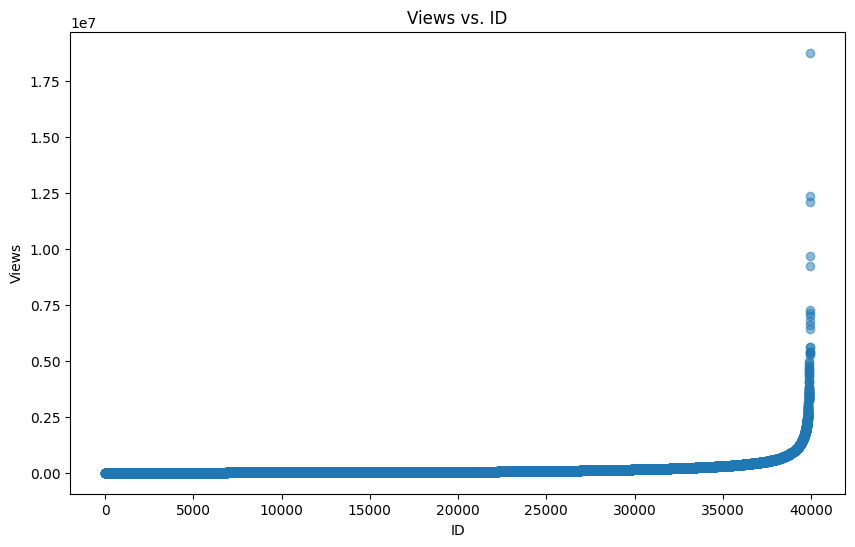

In [21]:
index_array = plot_data.index.to_numpy() + 1
plt.figure(figsize=(10, 6))
plt.scatter(index_array, plot_data['Views'], alpha=0.5)
plt.title('Views vs. ID')
plt.xlabel('ID')
plt.ylabel('Views')
plt.show()

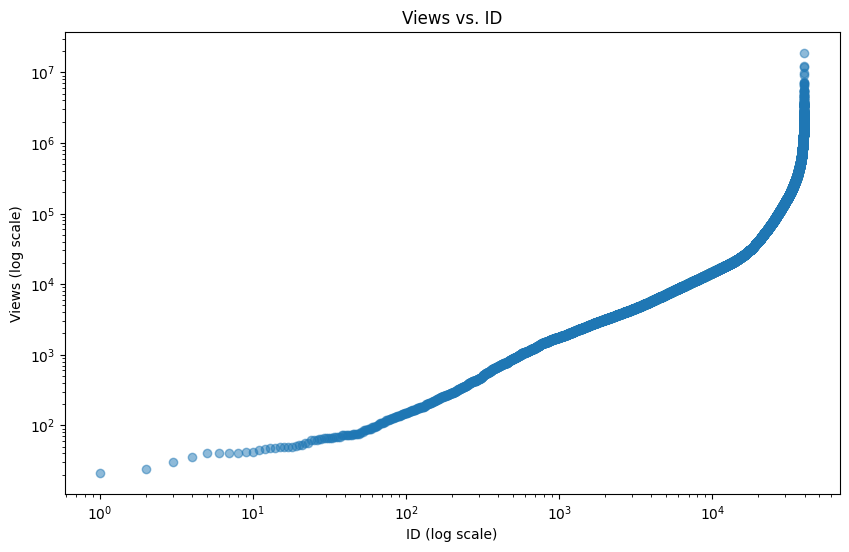

In [22]:


#plot scatter with views on y axis and id on x axis, make x axis log scale
plt.figure(figsize=(10, 6))
plt.scatter(index_array, plot_data['Views'], alpha=0.5)
plt.title('Views vs. ID')
plt.xlabel('ID (log scale)')
plt.ylabel('Views (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.show()

Veja que, mesmo usando a escala logarítmica que tende a linearizar a distribuição, alguns vídeos viralizam muito (demonstrado pelo crescimentos exponencial à direita)

## Preparando os dados

Aqui vamos pré-processar os dados para alimentarem os modelos de aprendizado de máquina que usaremos nesse processo:

### Pulando o processamento, preparação e carregamento de dados grandes

Dado o tamanho significante do dataset, disponibilizamos na raíz do projeto um diretório chamado saved_info que contém todos os dados que demoram ser carregados ou salvos para economizar tempo. Veja que isso é necessário pois o tensor de thumbnails processados possui 29GB ent ter isso já pronto facilita o uso do notebook.

Certifique-se de setar a variável skip_prep como True para possibilitar isso.

In [23]:
skip_prep = False

if skip_prep:
    
    thumbnails = np.load('saved_info/thumbnails.npy')

    scaled_features = pd.read_pickle('saved_info/scaled_features/scaled_features.pkl')
    scaler = joblib.load('saved_info/scaled_features/scaler.pkl')

    # load feature np arrays
    X_train_img = np.load('saved_info/pre_model_features/X_train_img.npy')
    X_test_img = np.load('saved_info/pre_model_features/X_test_img.npy')
    X_train_title = np.load('saved_info/pre_model_features/X_train_title.npy')
    X_test_title = np.load('saved_info/pre_model_features/X_test_title.npy')
    X_train_tags = np.load('saved_info/pre_model_features/X_train_tags.npy')
    X_test_tags = np.load('saved_info/pre_model_features/X_test_tags.npy')
    X_train_subs = np.load('saved_info/features/X_train_subs.npy')
    X_test_subs = np.load('saved_info/features/X_test_subs.npy')
    X_train_views = np.load('saved_info/features/X_train_views.npy')
    X_test_views = np.load('saved_info/features/X_test_views.npy')
    X_train_videos = np.load('saved_info/features/X_train_videos.npy')
    X_test_videos = np.load('saved_info/features/X_test_videos.npy')
    X_train_date = np.load('saved_info/features/X_train_date.npy')
    X_test_date = np.load('saved_info/features/X_test_date.npy')
    X_train_duration = np.load('saved_info/features/X_train_duration.npy')
    X_test_duration = np.load('saved_info/features/X_test_duration.npy')
    X_train_one_hot = np.load('saved_info/features/X_train_one_hot.npy')
    X_test_one_hot = np.load('saved_info/features/X_test_one_hot.npy')
    y_train_views = np.load('saved_info/features/y_train_views.npy')
    y_test_views = np.load('saved_info/features/y_test_views.npy')
    y_train_likes = np.load('saved_info/features/y_train_likes.npy')
    y_test_likes = np.load('saved_info/features/y_test_likes.npy')

    scaled_features_train = pd.read_pickle('saved_info/scaled_features/scaled_features_train.pkl')
    scaled_features_test = pd.read_pickle('saved_info/scaled_features/scaled_features_test.pkl')

    train_indices = np.load('saved_info/features/train_indices.npy')
    test_indices = np.load('saved_info/features/test_indices.npy')

### Funções de pré processamento

Aqui vamos criar algumas funções que serão necessárias no pré-processamento dos nossos dados

In [24]:
# Function to preprocess titles
def preprocess_titles(titles, max_length=20):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(titles)
    sequences = tokenizer.texts_to_sequences(titles)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences, tokenizer

In [25]:
# Function to preprocess tags
def preprocess_tags(tags_list, max_length=20):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tags_list)
    sequences = tokenizer.texts_to_sequences(tags_list)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences, tokenizer

In [26]:
# Function to load and preprocess the thumbnail image
def preprocess_and_load_image(image_name, image_dir):
    img_path = os.path.join(image_dir, image_name)
    img_path += '.jpg'  # Add the file extension
    img = load_img(img_path, target_size=(224, 224))  # Resize to 224x224 for VGG16
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    return img_array

### Pré-processando os dados

Aqui vamos efetivamente pré-processar os dados. Como dito antes, vamos salvar os tensores no diretório saved_info.

In [27]:
# Preprocess the titles
titles, title_tokenizer = preprocess_titles(data['Title'].values)

In [28]:
# Preprocess the tags
tags, tags_tokenizer = preprocess_tags(data['Tags'].apply(lambda x: ' '.join(x) if len(x) > 0 else 'empty').values)

In [29]:
if not skip_prep:
    # Load and preprocess images
    thumbnails = np.array([preprocess_and_load_image(image_name, thumbnails_dir)[0] for image_name in data['Video ID'].values])

In [30]:
if not skip_prep:
    # save loaded thumbnail images
    np.save('saved_info/thumbnails.npy', thumbnails)

In [31]:
one_hot_columns = data.columns[data.columns.str.startswith('Published Day of Week_') | data.columns.str.startswith('Published Time of Day_')].tolist()

In [32]:
# Create directory for scaled features
if not os.path.exists('saved_info/scaled_features'):
    os.makedirs('saved_info/scaled_features')

In [33]:

if not skip_prep:
    scaler = StandardScaler()

    # Create new dataframe that will contain the preprocessed numerical features from the original data
    scaled_features = data.copy()

    # Normalize the numerical features
    scaler = StandardScaler()
    scaled_features['Subscriber Count'] = scaler.fit_transform(scaled_features['Subscriber Count'].values.reshape(-1, 1))
    scaled_features['Total Views'] = scaler.fit_transform(scaled_features['Total Views'].values.reshape(-1, 1))
    scaled_features['Video Count'] = scaler.fit_transform(scaled_features['Video Count'].values.reshape(-1, 1))
    scaled_features['Date Posted'] = scaler.fit_transform(scaled_features['Date Posted'].values.reshape(-1, 1))
    scaled_features['Duration (Seconds)'] = scaler.fit_transform(scaled_features['Duration (Seconds)'].values.reshape(-1, 1))

    # Combine the one-hot encoded columns with the other features
    scaled_features[one_hot_columns] = scaled_features[one_hot_columns].astype('float32')

    scaled_features.to_pickle('saved_info/scaled_features/scaled_features.pkl')
    joblib.dump(scaler, 'saved_info/scaled_features/scaler.pkl')
    


### Dividindo os dados em treino e teste

In [34]:
if not skip_prep:
    # Split the data into train and test sets
    X_train_img, X_test_img, X_train_title, X_test_title, X_train_tags, X_test_tags, scaled_features_train, scaled_features_test = train_test_split(
        thumbnails, titles, tags, scaled_features, test_size=0.2, random_state=42)
    
    train_indices = scaled_features_train.index
    test_indices = scaled_features_test.index

In [35]:
X_train_subs = scaled_features_train['Subscriber Count'].values.reshape(-1, 1)
X_test_subs = scaled_features_test['Subscriber Count'].values.reshape(-1, 1)
X_train_views = scaled_features_train['Total Views'].values.reshape(-1, 1)
X_test_views = scaled_features_test['Total Views'].values.reshape(-1, 1)
X_train_videos = scaled_features_train['Video Count'].values.reshape(-1, 1)
X_test_videos = scaled_features_test['Video Count'].values.reshape(-1, 1)
X_train_date = scaled_features_train['Date Posted'].values  .reshape(-1, 1)
X_test_date = scaled_features_test['Date Posted'].values.reshape(-1, 1)
X_train_duration = scaled_features_train['Duration (Seconds)'].values.reshape(-1, 1)
X_test_duration = scaled_features_test['Duration (Seconds)'].values.reshape(-1, 1)
X_train_one_hot = scaled_features_train[one_hot_columns].values
X_test_one_hot = scaled_features_test[one_hot_columns].values
y_train_views = scaled_features_train['Views']
y_test_views = scaled_features_test['Views']
y_train_likes = scaled_features_train['Likes']
y_test_likes = scaled_features_test['Likes']

In [36]:
# Create directory for pre_model_features
if not os.path.exists('saved_info/pre_model_features/'):
    os.makedirs('saved_info/pre_model_features/')

# Create directory for features
if not os.path.exists('saved_info/features/'):
    os.makedirs('saved_info/features/')

if not skip_prep:
    # save feature np arrays
    np.save('saved_info/pre_model_features/X_train_img.npy', X_train_img)
    np.save('saved_info/pre_model_features/X_test_img.npy', X_test_img)
    np.save('saved_info/pre_model_features/X_train_title.npy', X_train_title)
    np.save('saved_info/pre_model_features/X_test_title.npy', X_test_title)
    np.save('saved_info/pre_model_features/X_train_tags.npy', X_train_tags)
    np.save('saved_info/pre_model_features/X_test_tags.npy', X_test_tags)
    np.save('saved_info/features/X_train_subs.npy', X_train_subs)
    np.save('saved_info/features/X_test_subs.npy', X_test_subs)
    np.save('saved_info/features/X_train_views.npy', X_train_views)
    np.save('saved_info/features/X_test_views.npy', X_test_views)
    np.save('saved_info/features/X_train_videos.npy', X_train_videos)
    np.save('saved_info/features/X_test_videos.npy', X_test_videos)
    np.save('saved_info/features/X_train_date.npy', X_train_date)
    np.save('saved_info/features/X_test_date.npy', X_test_date)
    np.save('saved_info/features/X_train_duration.npy', X_train_duration)
    np.save('saved_info/features/X_test_duration.npy', X_test_duration)
    np.save('saved_info/features/X_train_one_hot.npy', X_train_one_hot)
    np.save('saved_info/features/X_test_one_hot.npy', X_test_one_hot)
    np.save('saved_info/features/y_train_views.npy', y_train_views)
    np.save('saved_info/features/y_test_views.npy', y_test_views)
    np.save('saved_info/features/y_train_likes.npy', y_train_likes)
    np.save('saved_info/features/y_test_likes.npy', y_test_likes)

    scaled_features_train.to_pickle('saved_info/scaled_features/scaled_features_train.pkl')
    scaled_features_test.to_pickle('saved_info/scaled_features/scaled_features_test.pkl')
    
    np.save('saved_info/features/train_indices.npy', train_indices)
    np.save('saved_info/features/test_indices.npy', test_indices)


# Implementando modelos para extração de features

## Pulando os passos de extração

Como antes, vamos habilitar opções para pular os passos de implementação e extração de features dado o tamanho do dataset.

Não esqueça de setar skip_ext como True para possibilitar isso.

In [37]:
skip_ext = False

if skip_ext:
    # Load features from disk
    X_train_img_features = np.load('saved_info/post_model_features/X_train_img_features.npy')
    X_test_img_features = np.load('saved_info/post_model_features/X_test_img_features.npy')

    X_train_title_features = np.load('saved_info/post_model_features/X_train_title_features.npy')
    X_test_title_features = np.load('saved_info/post_model_features/X_test_title_features.npy')

    X_train_tags_features = np.load('saved_info/post_model_features/X_train_tags_features.npy')
    X_test_tags_features = np.load('saved_info/post_model_features/X_test_tags_features.npy')

    X_train_combined = np.load('saved_info/final_features/X_train_combined.npy')
    X_test_combined = np.load('saved_info/final_features/X_test_combined.npy')

## Implementando Convolutional Neural Network para extração de features das thumbnails

### Implementação

In [38]:
# Load the pretrained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [39]:
# Add new layers on top of the pretrained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
img_output = Dense(128, activation='relu')(x)
img_model = Model(inputs=base_model.input, outputs=img_output)

### Extração

In [40]:
if not skip_ext:
    # Extract features from images
    try:
        X_train_img_features = img_model.predict(X_train_img, batch_size=32, verbose=1)
        X_test_img_features = img_model.predict(X_test_img, batch_size=32, verbose=1)
    except Exception as e:
        print(f"An error occurred during feature extraction: {e}")

999/999 ━━━━━━━━━━━━━━━━━━━━ 3586s 4s/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 928s 4s/step


In [41]:
# Create directory for post_model_features
if not os.path.exists('saved_info/post_model_features/'):
    os.makedirs('saved_info/post_model_features/')

In [42]:
if not skip_ext:
    # Save features to disk
    np.save('saved_info/post_model_features/X_train_img_features.npy', X_train_img_features)
    np.save('saved_info/post_model_features/X_test_img_features.npy', X_test_img_features)

## Implementando Recurrent Neural Network para extração de features do título

### Implementação

In [52]:
# Text input branch for title
title_input = Input(shape=(X_train_title.shape[1],))
y = Embedding(input_dim=len(title_tokenizer.word_index) + 1, output_dim=128)(title_input)
y = LSTM(64)(y)
title_output = Dense(128, activation='relu')(y)
title_model = Model(inputs=title_input, outputs=title_output)

### Extração

In [53]:
if not skip_ext:
    # Extract features from titles
    X_train_title_features = title_model.predict(X_train_title, batch_size=32, verbose=1)
    X_test_title_features = title_model.predict(X_test_title, batch_size=32, verbose=1)

999/999 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [54]:
if not skip_ext:
    # Save features to disk
    np.save('saved_info/post_model_features/X_train_title_features.npy', X_train_title_features)
    np.save('saved_info/post_model_features/X_test_title_features.npy', X_test_title_features)

## Implementando Recurrent Neural Network para extração de features dos tags do vídeo

In [46]:
# Text input branch for tags
tags_input = Input(shape=(X_train_tags.shape[1],))
t = Embedding(input_dim=len(tags_tokenizer.word_index) + 1, output_dim=128)(tags_input)
t = LSTM(64)(t)
tags_output = Dense(128, activation='relu')(t)
tags_model = Model(inputs=tags_input, outputs=tags_output)

In [47]:
if not skip_ext:
    # Extract features from tags
    X_train_tags_features = tags_model.predict(X_train_tags, batch_size=32, verbose=1)
    X_test_tags_features = tags_model.predict(X_test_tags, batch_size=32, verbose=1)

999/999 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [48]:
if not skip_ext:
    # Save features to disk
    np.save('saved_info/post_model_features/X_train_tags_features.npy', X_train_tags_features)
    np.save('saved_info/post_model_features/X_test_tags_features.npy', X_test_tags_features)

## Juntando todas as saídas 

In [55]:
if not skip_ext:
    # Combine all features
    X_train_combined = np.concatenate([X_train_img_features, X_train_title_features, X_train_tags_features, X_train_subs, X_train_views, X_train_videos, X_train_date, X_train_duration, X_train_one_hot], axis=1)
    X_test_combined = np.concatenate([X_test_img_features, X_test_title_features, X_test_tags_features, X_test_subs, X_test_views, X_test_videos, X_test_date, X_test_duration, X_test_one_hot], axis=1)

In [56]:
# Create directory for final_features
if not os.path.exists('saved_info/final_features/'):
    os.makedirs('saved_info/final_features/')

In [57]:
if not skip_ext:
    # Save features to disk
    np.save('saved_info/final_features/X_train_combined.npy', X_train_combined)
    np.save('saved_info/final_features/X_test_combined.npy', X_test_combined)

# Implementando os modelos de Random Forest

Agora vamos implementar a última camada do nosso modelo que são dois random forests:
1) Um para predizer o número de views de um vídeo
2) Outro para predizer o número de likes de um vídeo

## Pulando o cross validation

Como antes, vamos possibilitar pular os passos de cross validation do nosso modelo dado a demora de se executar.

Certifique-se de setar skip_cval como True para possibilitar isso

In [60]:
skip_cval = False

if skip_cval:
    grid_search_views = joblib.load('saved_info/grids/grid_search_views.pkl')
    grid_search_likes = joblib.load('saved_info/grids/grid_search_likes.pkl')

## 5-Fold Cross Validation para encontrar a combinação de parâmetros ótimo

Vamos primeiro testar nosso modelo com diferentes parâmetros para ver qual possui melhor desempenho. Para isso, vamos usar o 5-Fold Cross Validation, que também nos permitirá ter um senso melhor da generalizção do modelo.

In [61]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 1, 5, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_views = RandomForestRegressor(random_state=42)

# Set up the Grid Search
grid_search_views = GridSearchCV(estimator=rf_views, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', return_train_score=True)

In [62]:
if not skip_cval:
    # Fit the Grid Search model for views prediction
    grid_search_views = grid_search_views.fit(X_train_combined, y_train_views)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


python(13236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13246) Malloc

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_

/opt/anaconda3/envs/youtube_video_downloader/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [63]:
# Create directory for grids
if not os.path.exists('saved_info/grids/'):
    os.makedirs('saved_info/grids/')

In [64]:
if not skip_cval:
    joblib.dump(grid_search_views, 'saved_info/grids/grid_search_views.pkl')

In [65]:
# Initialize the Random Forest model
rf_likes = RandomForestRegressor(random_state=42)

# Set up the Grid Search
grid_search_likes = GridSearchCV(estimator=rf_likes, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', return_train_score=True)

In [66]:
if not skip_cval:
    # Fit the Grid Search model for likes prediction
    grid_search_likes = grid_search_likes.fit(X_train_combined, y_train_likes)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=10; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=10; total time=   5.0s


/opt/anaconda3/envs/youtube_video_downloader/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [67]:
if not skip_cval:
    joblib.dump(grid_search_likes, 'saved_info/grids/grid_search_likes.pkl')

### Resultados do Cross Validation

#### Resultados para views

In [80]:
best_params_views = grid_search_views.best_params_

print("Best parameters for views prediction:")
print(best_params_views)

Best parameters for views prediction:
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}


In [81]:
print(f"Best mean absolute test error for views model: {-grid_search_views.best_score_}")
print(f"Best mean absolute train error for views model: {-grid_search_views.cv_results_['mean_train_score'][grid_search_views.best_index_]}")

Best mean absolute test error for views model: 117158.98612372056
Best mean absolute train error for views model: 52920.39737452885


In [92]:
# Extract the results into a DataFrame for views prediction
results_views = pd.DataFrame(grid_search_views.cv_results_)

results_views['mean_test_score'] = -results_views['mean_test_score']
results_views['mean_train_score'] = -results_views['mean_train_score']

# remove rows with NaN values
results_views['param_max_depth'].fillna(50, inplace=True)
results_views['param_max_depth'] = results_views['param_max_depth'].astype(int)

/var/folders/dn/hygmyj2x0d32s33qbm_7mnvh0000gn/T/ipykernel_92442/2650641302.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_views['param_max_depth'].fillna(50, inplace=True)
/var/folders/dn/hygmyj2x0d32s33qbm_7mnvh0000gn/T/ipykernel_92442/2650641302.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


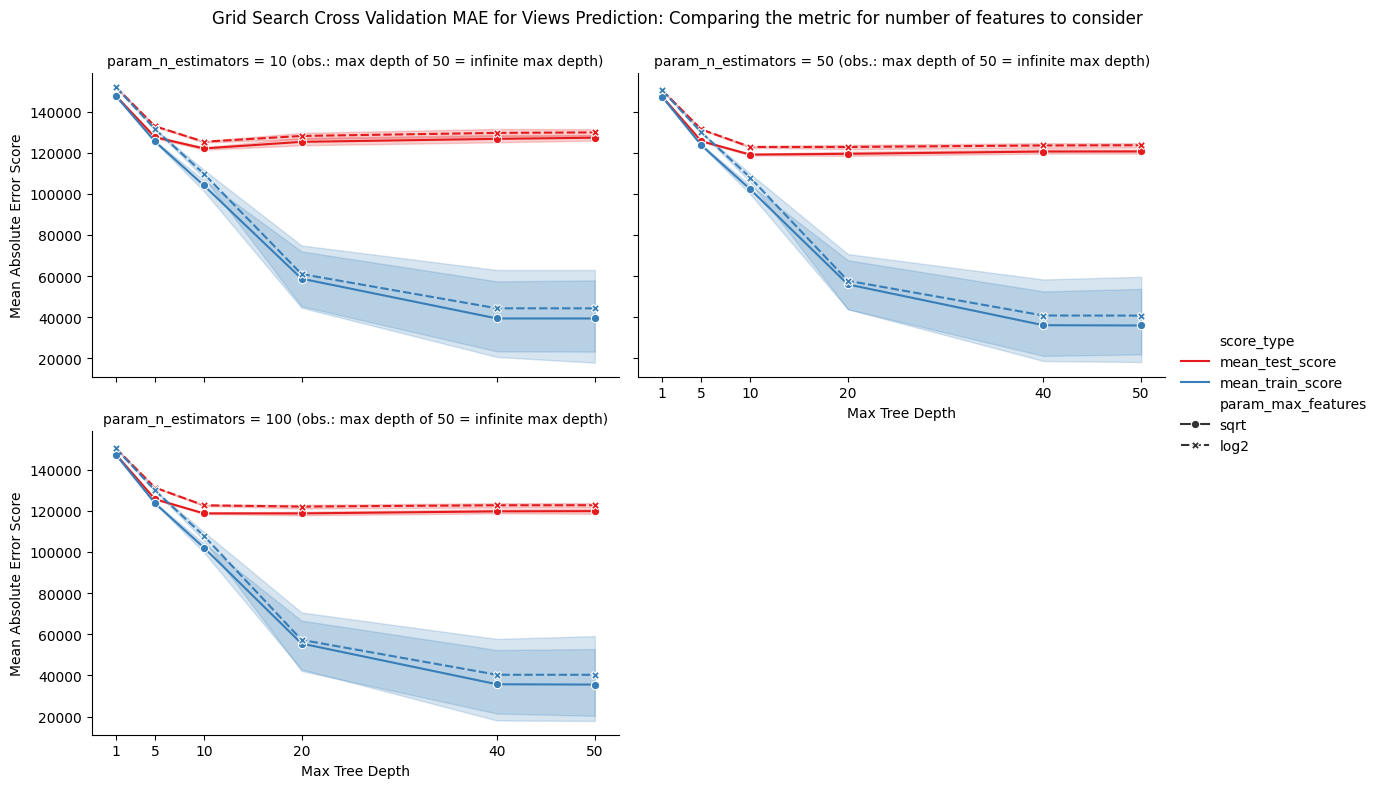

In [93]:
# Melt the DataFrame
melted_df = pd.melt(results_views, 
                    id_vars=['param_max_depth', 'param_n_estimators', 'param_max_features', 'param_bootstrap', 'param_min_samples_split'],
                    value_vars=['mean_test_score', 'mean_train_score'],
                    var_name='score_type',
                    value_name='score')

# Plot with hue determining if it is the mean test score or mean train score
g = sns.FacetGrid(melted_df, col='param_n_estimators', col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='param_max_depth', y='score', hue='score_type', style='param_max_features', markers=True, dashes=True, palette='Set1')
g.add_legend()
g.set_axis_labels("Max Tree Depth", "Mean Absolute Error Score")
g.set_titles(col_template="param_n_estimators = {col_name} (obs.: max depth of 50 = infinite max depth)")
plt.subplots_adjust(top=0.9)
# list comprehension to remove None from xticks and substitute with 'Infinite'
plt.xticks([50 if i is None else i for i in param_grid['max_depth']])
g.fig.suptitle('Grid Search Cross Validation MAE for Views Prediction: Comparing the metric for number of features to consider')
plt.show()

- Como podemos ver, o uso de sqrt como métrica para determinar o número de features a serem consideradas na hora de achar o melhor nó possui um desempenho levemente superior.

- Além disso, podemos ver que quanto mais profundas as árvores:
    - Nos dados de treino:
        - Maior a variância incorrendo risco de overfitting (que não acontece completamente por estarmos usando random forests). Podemos observar esse aumento de variância pelo aumento do intervalo de confiança significativo.
        - O erro diminiu muito mostrando que o modelo está decorando os dados, mas sem uma melhora na sua generalização.
    - Nos dados de teste:
        - A variância cresce levemente
        - O erro diminui em um primeiro momento mas depois estagna e por fim inicia um pequeno aumento
    - Assim, quanto mais profundas as árvores maior a divergência entre treino e teste. Porém devido à randomicidade que é inerente ao modelo de random forest não incorremos em um perda grande demais de generalização.

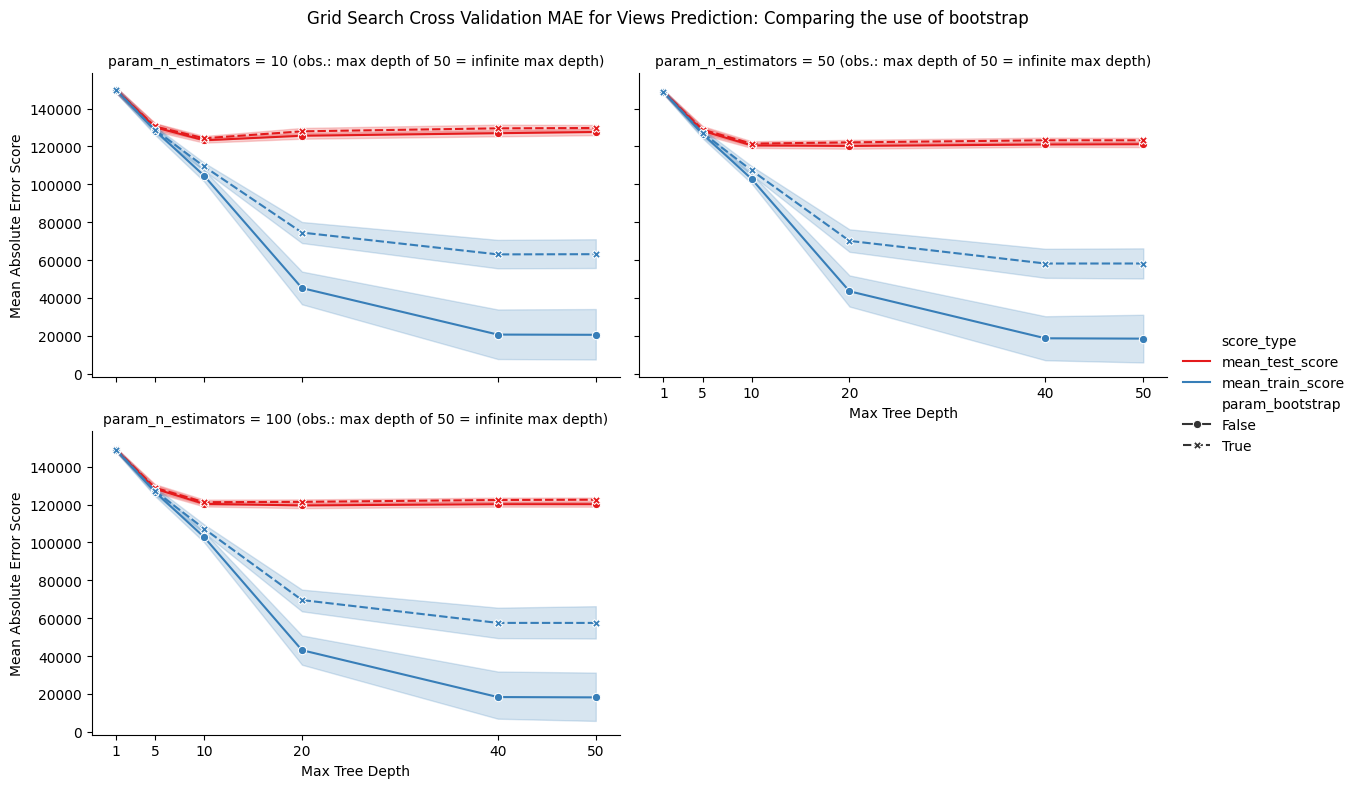

In [94]:
# Plot with hue determining if it is the mean test score or mean train score
g = sns.FacetGrid(melted_df, col='param_n_estimators', col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='param_max_depth', y='score', hue='score_type', style='param_bootstrap', markers=True, dashes=True, palette='Set1')
g.add_legend()
g.set_axis_labels("Max Tree Depth", "Mean Absolute Error Score")
g.set_titles(col_template="param_n_estimators = {col_name} (obs.: max depth of 50 = infinite max depth)")
plt.subplots_adjust(top=0.9)
plt.xticks([50 if i is None else i for i in param_grid['max_depth']])
g.fig.suptitle('Grid Search Cross Validation MAE for Views Prediction: Comparing the use of bootstrap')
plt.show()

- Diferente do que normalmente se vê, não usar bootstrap teve um resultado levemente melhor no teste. Isso se deve ao fato de que, temos poucos dados (relativamente) visto a complexidade do dado. Assim, não usar o bootstrap permite que o modelo veja mais dados e tenha um desempenho levemente melhor, porém com uma variância levemente maior também.

- Por outro lado, seguem as mesmas relações de profundidade de árvores com erro e variância

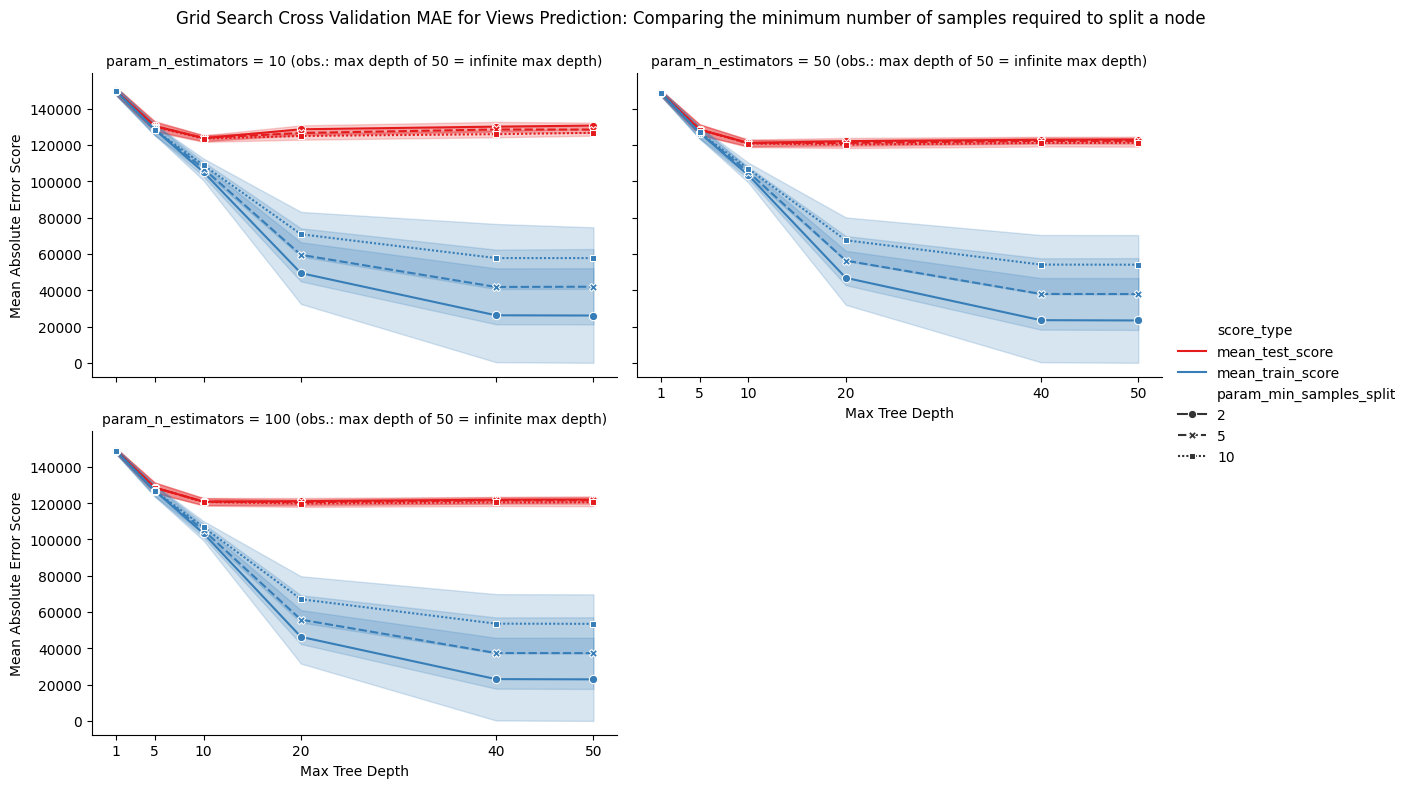

In [95]:
# Plot with hue determining if it is the mean test score or mean train score
g = sns.FacetGrid(melted_df, col='param_n_estimators', col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='param_max_depth', y='score', hue='score_type', style='param_min_samples_split', markers=True, dashes=True, palette='Set1')
g.add_legend()
g.set_axis_labels("Max Tree Depth", "Mean Absolute Error Score")
g.set_titles(col_template="param_n_estimators = {col_name} (obs.: max depth of 50 = infinite max depth)")
plt.subplots_adjust(top=0.9)
plt.xticks([50 if i is None else i for i in param_grid['max_depth']])
g.fig.suptitle('Grid Search Cross Validation MAE for Views Prediction: Comparing the minimum number of samples required to split a node')
plt.show()

- Como podemos ver, a métrica do número mínimo de amostras necessárias para particionar um nó tem baixa variação nos dados de teste, porém variação alta nos dados de treino. 

- Nos dados treino, quanto maior o número mínimo de amostras melhor resultado pois consegue aprender mais sobre o dado. 

- Porém nos dados de teste inverso ocorre (apesar de ser quase imperceptível). Isso se dá pois, quanto menor o número mínimo de amostras, mais rasas tendem a ser as árvores e consequentemente, melhor tende a ser o desempenho devido à randomicidade que é introduzida ao modelo, que permite uma melhor generalização.

#### Resultados para likes

In [86]:
best_params_likes = grid_search_likes.best_params_

print("\nBest parameters for likes prediction:")
print(best_params_likes)


Best parameters for likes prediction:
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}


In [87]:
print(f"Best mean absolute test error for likes model: {-grid_search_likes.best_score_}")
print(f"Best mean absolute train error for likes model: {-grid_search_likes.cv_results_['mean_train_score'][grid_search_likes.best_index_]}")

Best mean absolute test error for likes model: 8661.509576995217
Best mean absolute train error for likes model: 3605.237876277393


In [88]:
# Extract the results into a DataFrame for likes prediction
results_likes = pd.DataFrame(grid_search_likes.cv_results_)

results_likes['mean_test_score'] = -results_likes['mean_test_score']
results_likes['mean_train_score'] = -results_likes['mean_train_score']

# remove rows with NaN values
results_likes['param_max_depth'].fillna(50, inplace=True)
results_likes['param_max_depth'] = results_likes['param_max_depth'].astype(int)

/var/folders/dn/hygmyj2x0d32s33qbm_7mnvh0000gn/T/ipykernel_92442/1127478426.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_likes['param_max_depth'].fillna(40, inplace=True)
/var/folders/dn/hygmyj2x0d32s33qbm_7mnvh0000gn/T/ipykernel_92442/1127478426.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


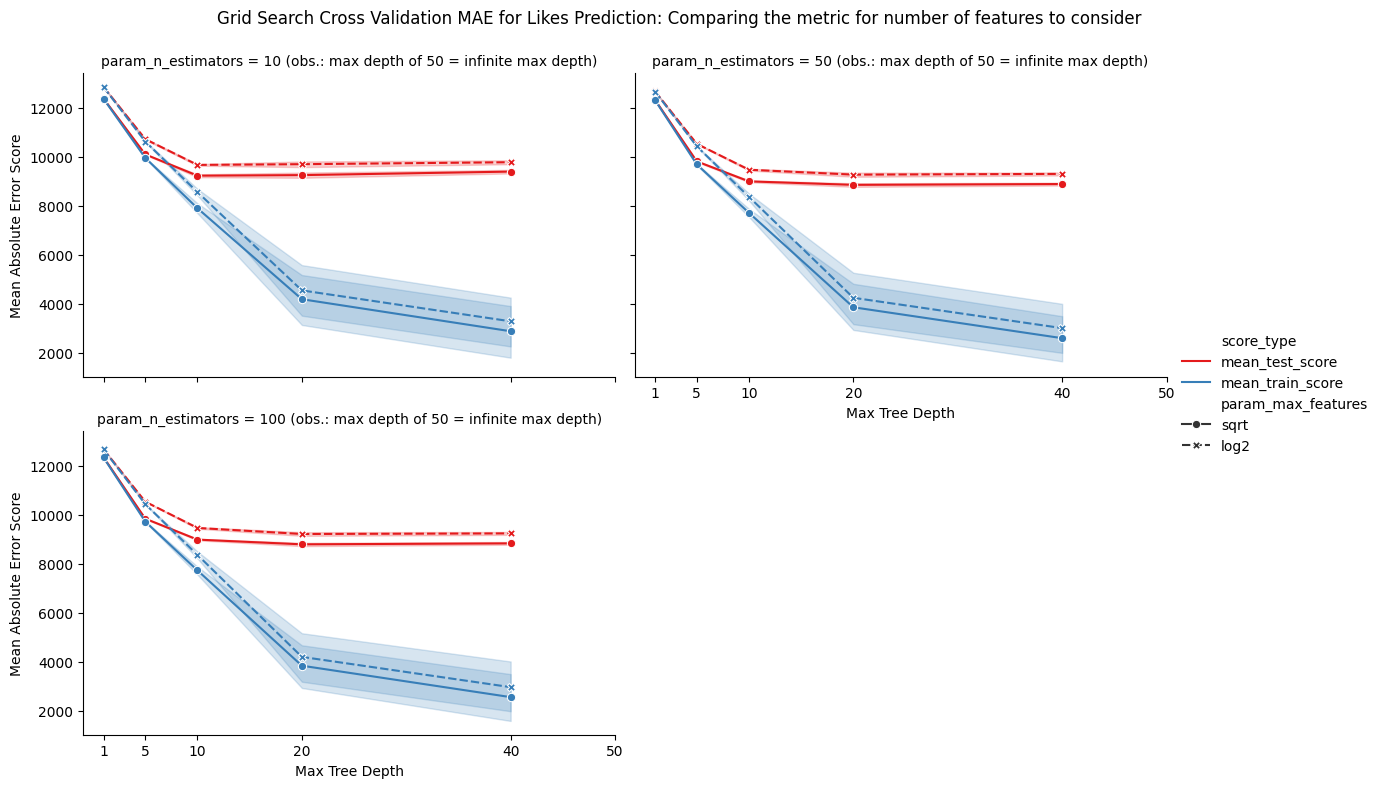

In [96]:
# Melt the DataFrame
melted_df = pd.melt(results_likes, 
                    id_vars=['param_max_depth', 'param_n_estimators', 'param_max_features', 'param_bootstrap', 'param_min_samples_split'],
                    value_vars=['mean_test_score', 'mean_train_score'],
                    var_name='score_type',
                    value_name='score')

# Plot with hue determining if it is the mean test score or mean train score
g = sns.FacetGrid(melted_df, col='param_n_estimators', col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='param_max_depth', y='score', hue='score_type', style='param_max_features', markers=True, dashes=True, palette='Set1')
g.add_legend()
g.set_axis_labels("Max Tree Depth", "Mean Absolute Error Score")
g.set_titles(col_template="param_n_estimators = {col_name} (obs.: max depth of 50 = infinite max depth)")
plt.subplots_adjust(top=0.9)
plt.xticks([50 if i is None else i for i in param_grid['max_depth']])
g.fig.suptitle('Grid Search Cross Validation MAE for Likes Prediction: Comparing the metric for number of features to consider')
plt.show()

- Para os likes seguimos as mesmas observções que para os views visto a alta correlação entre essas métricas tanto semanticamente quanto nos resultados de treino e teste.

- Como podemos ver, o uso de sqrt como métrica para determinar o número de features a serem consideradas na hora de achar o melhor nó possui um desempenho levemente superior.

- Além disso, podemos ver que quanto mais profundas as árvores:
    - Nos dados de treino:
        - Maior a variância incorrendo risco de overfitting (que não acontece completamente por estarmos usando random forests). Podemos observar esse aumento de variância pelo aumento do intervalo de confiança significativo.
        - O erro diminiu muito mostrando que o modelo está decorando os dados, mas sem uma melhora na sua generalização.
    - Nos dados de teste:
        - A variância cresce levemente
        - O erro diminui em um primeiro momento mas depois estagna e por fim inicia um pequeno aumento
    - Assim, quanto mais profundas as árvores maior a divergência entre treino e teste. Porém devido à randomicidade que é inerente ao modelo de random forest não incorremos em um perda grande demais de generalização.

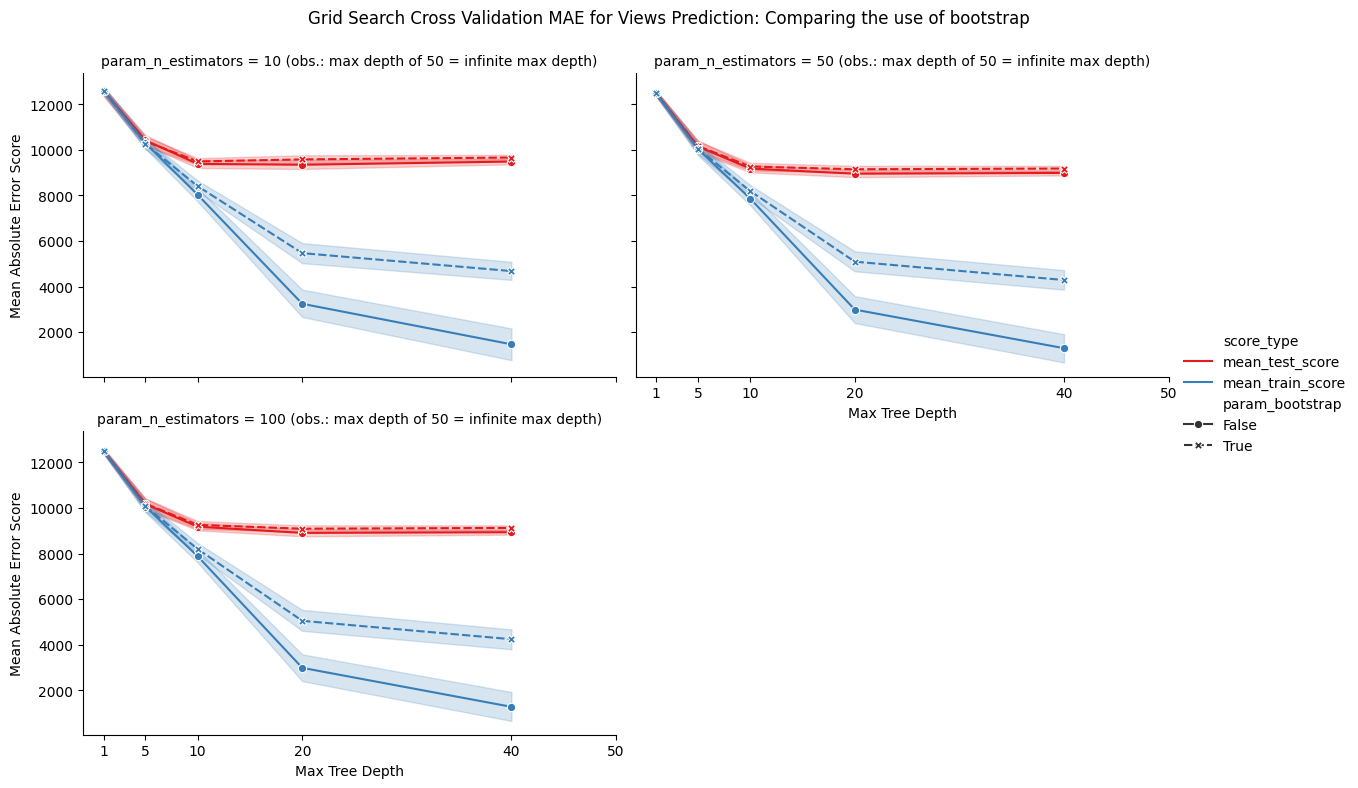

In [98]:
# Plot with hue determining if it is the mean test score or mean train score
g = sns.FacetGrid(melted_df, col='param_n_estimators', col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='param_max_depth', y='score', hue='score_type', style='param_bootstrap', markers=True, dashes=True, palette='Set1')
g.add_legend()
g.set_axis_labels("Max Tree Depth", "Mean Absolute Error Score")
g.set_titles(col_template="param_n_estimators = {col_name} (obs.: max depth of 50 = infinite max depth)")
plt.subplots_adjust(top=0.9)
plt.xticks([50 if i is None else i for i in param_grid['max_depth']])
g.fig.suptitle('Grid Search Cross Validation MAE for Views Prediction: Comparing the use of bootstrap')
plt.show()

- Diferente do que normalmente se vê, não usar bootstrap teve um resultado levemente melhor no teste. Isso se deve ao fato de que, temos poucos dados (relativamente) visto a complexidade do dado. Assim, não usar o bootstrap permite que o modelo veja mais dados e tenha um desempenho levemente melhor, porém com uma variância levemente maior também.

- Por outro lado, seguem as mesmas relações de profundidade de árvores com erro e variância

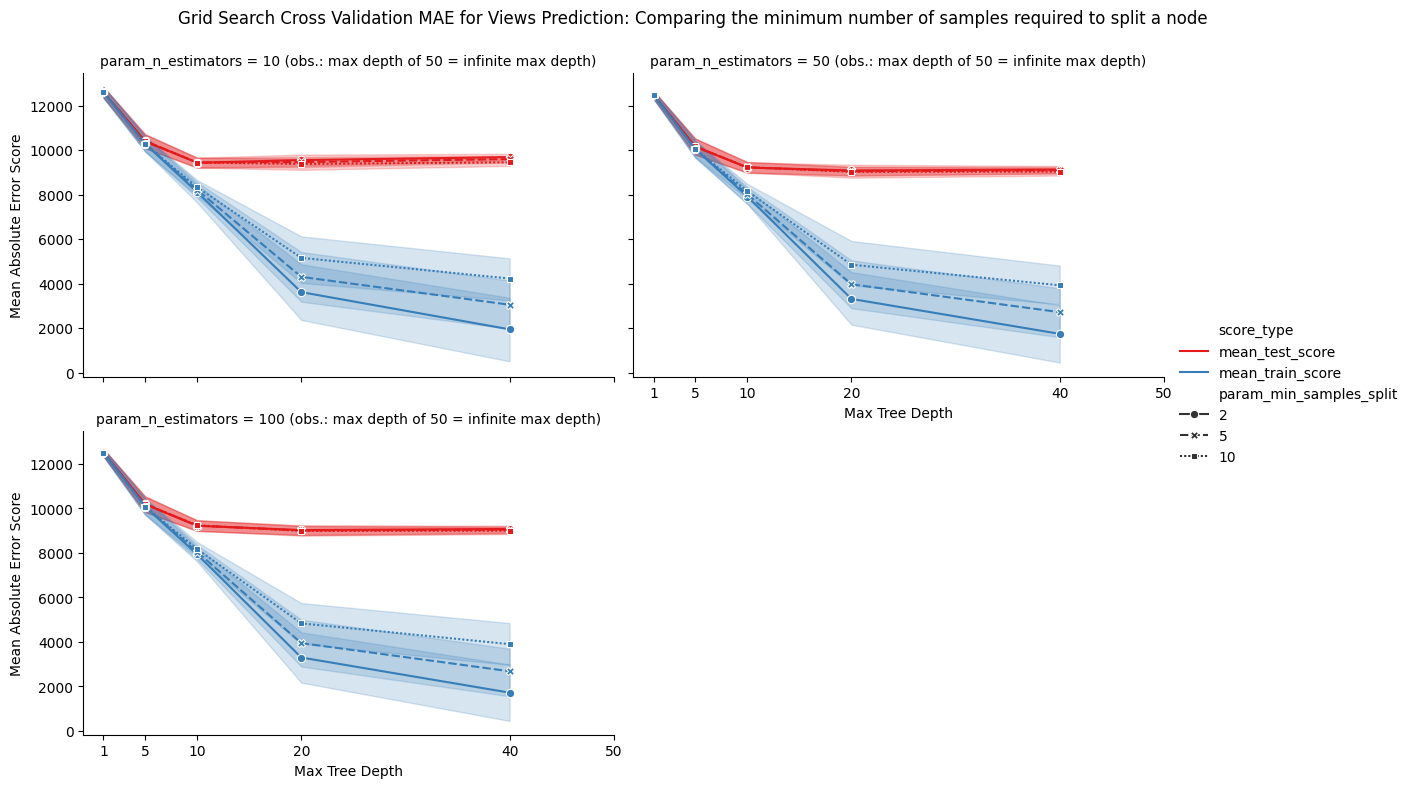

In [99]:
# Plot with hue determining if it is the mean test score or mean train score
g = sns.FacetGrid(melted_df, col='param_n_estimators', col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x='param_max_depth', y='score', hue='score_type', style='param_min_samples_split', markers=True, dashes=True, palette='Set1')
g.add_legend()
g.set_axis_labels("Max Tree Depth", "Mean Absolute Error Score")
g.set_titles(col_template="param_n_estimators = {col_name} (obs.: max depth of 50 = infinite max depth)")
plt.subplots_adjust(top=0.9)
plt.xticks([50 if i is None else i for i in param_grid['max_depth']])
g.fig.suptitle('Grid Search Cross Validation MAE for Views Prediction: Comparing the minimum number of samples required to split a node')
plt.show()

- Como podemos ver, a métrica do número mínimo de amostras necessárias para particionar um nó tem baixa variação nos dados de teste, porém variação alta nos dados de treino. 

- Nos dados treino, quanto maior o número mínimo de amostras melhor resultado pois consegue aprender mais sobre o dado. 

- Porém nos dados de teste inverso ocorre. Isso se dá pois, quanto menor o número mínimo de amostras, mais rasas tendem a ser as árvores e consequentemente, melhor tende a ser o desempenho devido à randomicidade que é introduzida ao modelo, que permite uma melhor generalização.

# Modelo Final

## Pular o retreinamento do melhor modelo

Como antes, vamos possibilitar que pule os passos de retreinamento do melhor modelo devido ao tamanho do dataset.

Certifique-se de setar o skip_ret como True para possibilitar isso.

In [100]:
skip_ret = False

if skip_ret:
    # Load the model from the file
    rf_views_final = joblib.load('saved_info/models/rf_views_final_model.pkl')
    rf_likes_final = joblib.load('saved_info/models/rf_likes_final_model.pkl')

    # load predictions from file
    y_pred_views_final = np.load('saved_info/predictions/y_pred_views_final.npy')
    y_pred_likes_final = np.load('saved_info/predictions/y_pred_likes_final.npy')

## Modelo de random forest para views

### Retreinando o melhor modelo com todos os dados de treino

In [101]:
if not skip_ret:
    # Train the final Random Forest model for views prediction using the best parameters
    rf_views_final = RandomForestRegressor(**best_params_views, random_state=42)
    rf_views_final.fit(X_train_combined, y_train_views)

In [102]:
# Create directory for models
if not os.path.exists('saved_info/models/'):
    os.makedirs('saved_info/models/')

In [103]:
if not skip_ret:
    joblib.dump(rf_views_final, 'saved_info/models/rf_views_final_model.pkl')

### Inferindo com o melhor modelo

In [104]:
# Create directory for predictions
if not os.path.exists('saved_info/predictions/'):
    os.makedirs('saved_info/predictions/')

In [105]:
if not skip_ret:
    y_pred_views_final = rf_views_final.predict(X_test_combined)

In [106]:
# Save the predictions to disk
if not skip_ret:
    np.save('saved_info/predictions/y_pred_views_final.npy', y_pred_views_final)

### Performance do melhor modelo

In [107]:
views_mae_final = mean_absolute_error(y_test_views, y_pred_views_final)

print(f'Mean Absolute Error for Views (Final Model): {views_mae_final}')

Mean Absolute Error for Views (Final Model): 118120.25794172753


In [108]:
# Calculate other metrics of performance
views_mse_final = mean_squared_error(y_test_views, y_pred_views_final)
views_rmse_final = np.sqrt(views_mse_final)
views_r2_final = r2_score(y_test_views, y_pred_views_final)
print(f'Mean Squared Error for Views (Final Model): {views_mse_final}')
print(f'Root Mean Squared Error for Views (Final Model): {views_rmse_final}')
print(f'R^2 Score for Views (Final Model): {views_r2_final}')

Mean Squared Error for Views (Final Model): 84975660326.59076
Root Mean Squared Error for Views (Final Model): 291505.8495581019
R^2 Score for Views (Final Model): 0.2170834476750928


In [109]:
# Calculate accuracy for views prediction within tolerance
tolerance = 0.3
correct_views = np.sum((y_pred_views_final >= (1 - tolerance) * y_test_views) & (y_pred_views_final <= (1 + tolerance) * y_test_views))
accuracy_views = correct_views / len(y_test_views)
print(f'Accuracy for Views Prediction (Final Model): {accuracy_views:.2%}')
print(f'Number of Correct Predictions within Tolerance: {correct_views}')
print(f'Number of Incorrect Predictions: {len(y_test_views) - correct_views}')

Accuracy for Views Prediction (Final Model): 22.36%
Number of Correct Predictions within Tolerance: 1786
Number of Incorrect Predictions: 6202


Como podemos ver, o desempenho do noss modelo é pouco satisfatório, mesmo considerando uma tolerância de 30%. Isso se deve ao fato que vimos anteriormente: precisamos de mais dados para que possamos realmente aprender a predizer o número de views dado as informações que temos do nosso vídeo antes de postá-lo

In [110]:
# Get indices for the correct predictions
correct_indices = np.where((y_pred_views_final >= (1 - tolerance) * y_test_views) & (y_pred_views_final <= (1 + tolerance) * y_test_views))[0]

# Get indices for the incorrect predictions
incorrect_indices = np.where((y_pred_views_final < (1 - tolerance) * y_test_views) | (y_pred_views_final > (1 + tolerance) * y_test_views))[0]

In [111]:
scaled_train_df = scaled_features_train.copy()
scaled_test_df = scaled_features_test.copy()
complete_scaled_df = scaled_features.copy()
complete_normal_df = data.copy()

In [112]:
scaled_test_df['Views Prediction'] = y_pred_views_final

In [113]:
incorrect_predictions = scaled_test_df.iloc[incorrect_indices]
correct_predictions = scaled_test_df.iloc[correct_indices]

In [114]:
sorted_scaled_df = scaled_test_df.sort_values(by='Views', ascending=True)
sorted_scaled_views = sorted_scaled_df['Views']
sorted_scaled_indices = sorted_scaled_views.index.to_numpy()

sorted_incorrect_scaled_df = incorrect_predictions.sort_values(by='Views', ascending=True)
sorted_incorrect_scaled_views_pred = sorted_incorrect_scaled_df['Views Prediction']
sorted_incorrect_scaled_views_pred_indices = sorted_incorrect_scaled_views_pred.index.to_numpy()

sorted_correct_scaled_df = correct_predictions.sort_values(by='Views', ascending=True)
sorted_correct_scaled_views_pred = sorted_correct_scaled_df['Views Prediction']
sorted_correct_scaled_views_pred_indices = sorted_correct_scaled_views_pred.index.to_numpy()

sorted_incorrect_scaled_views = sorted_incorrect_scaled_df['Views']
sorted_incorrect_scaled_indices = sorted_incorrect_scaled_views.index.to_numpy()

sorted_correct_scaled_views = sorted_correct_scaled_df['Views']
sorted_correct_scaled_indices = sorted_correct_scaled_views.index.to_numpy()

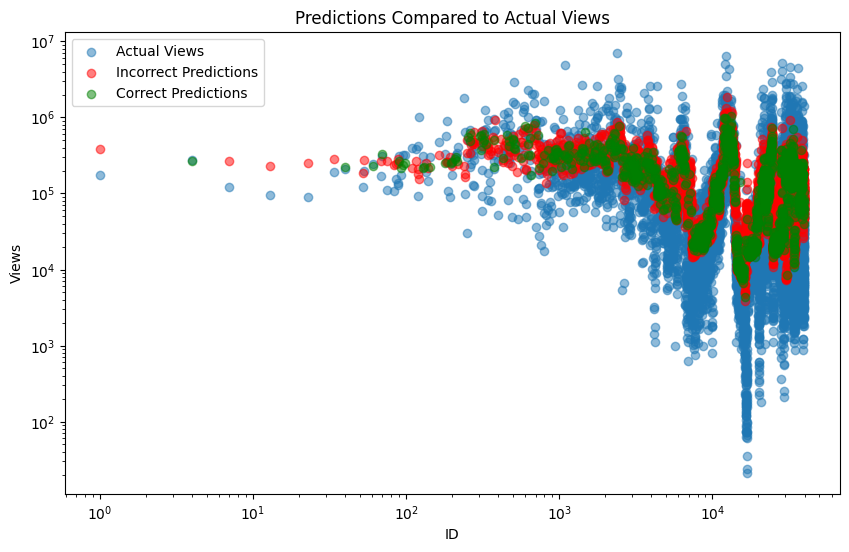

In [115]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_scaled_indices, sorted_scaled_views, label='Actual Views', alpha=0.5)
plt.scatter(sorted_incorrect_scaled_views_pred_indices, sorted_incorrect_scaled_views_pred, label='Incorrect Predictions', color='red', alpha=0.5)
plt.scatter(sorted_correct_scaled_views_pred_indices, sorted_correct_scaled_views_pred, label='Correct Predictions', color='green', alpha=0.5)
plt.xlabel('ID')
plt.ylabel('Views')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Predictions Compared to Actual Views')
plt.show()

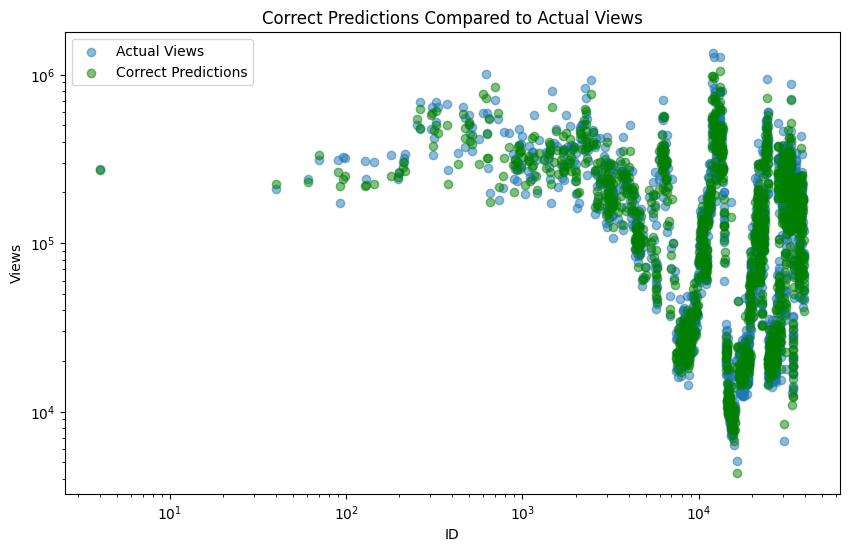

In [116]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_correct_scaled_indices, sorted_correct_scaled_views, label='Actual Views', alpha=0.5)
plt.scatter(sorted_correct_scaled_views_pred_indices, sorted_correct_scaled_views_pred, label='Correct Predictions', color='green', alpha=0.5)
plt.xlabel('ID')
plt.ylabel('Views')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Correct Predictions Compared to Actual Views')
plt.show()

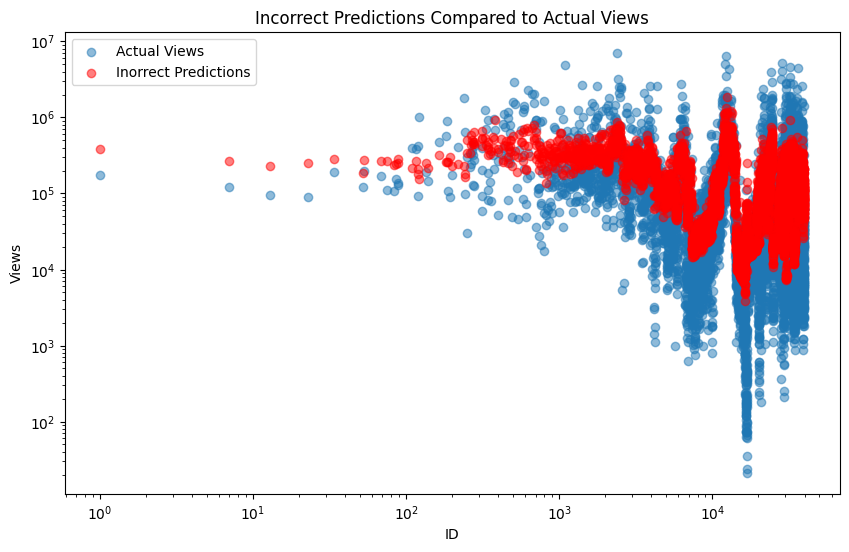

In [117]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_incorrect_scaled_indices, sorted_incorrect_scaled_views, label='Actual Views', alpha=0.5)
plt.scatter(sorted_incorrect_scaled_views_pred_indices, sorted_incorrect_scaled_views_pred, label='Inorrect Predictions', color='red', alpha=0.5)
plt.xlabel('ID')
plt.ylabel('Views')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Incorrect Predictions Compared to Actual Views')
plt.show()

Como podemos ver nos últimos dois plots, a tolerância garante que as predições corretas estejam perto e não apenas exatemente sobreposto ao views reais. Da mesma forma, as predições incorretas estão claramente desarmônicos com as views reais.

## Modelo de random forest para likes

### Retreinando o melhor modelo com todos os dados de treino

In [118]:
if not skip_ret:
    # Train the final Random Forest model for likes prediction using the best parameters
    rf_likes_final = RandomForestRegressor(**best_params_likes, random_state=42)
    rf_likes_final.fit(X_train_combined, y_train_likes)

In [119]:
# Create directory for models
if not os.path.exists('saved_info/models/'):
    os.makedirs('saved_info/models/')

In [120]:
if not skip_ret:
    joblib.dump(rf_likes_final, 'saved_info/models/rf_likes_final_model.pkl')

### Inferindo com o melhor modelo

In [121]:
# Create directory for predictions
if not os.path.exists('saved_info/predictions/'):
    os.makedirs('saved_info/predictions/')

In [122]:
if not skip_ret:
    y_pred_likes_final = rf_likes_final.predict(X_test_combined)

In [123]:
# Save the predictions to disk
if not skip_ret:
    np.save('saved_info/predictions/y_pred_likes_final.npy', y_pred_likes_final)

### Performance do melhor modelo

In [124]:
likes_mae_final = mean_absolute_error(y_test_likes, y_pred_likes_final)

print(f'Mean Absolute Error for Likes (Final Model): {likes_mae_final}')

Mean Absolute Error for Likes (Final Model): 8982.200200842055


In [125]:
# Calculate other metrics of performance
likes_mse_final = mean_squared_error(y_test_likes, y_pred_likes_final)
likes_rmse_final = np.sqrt(likes_mse_final)
likes_r2_final = r2_score(y_test_likes, y_pred_likes_final)
print(f'Mean Squared Error for Likes (Final Model): {likes_mse_final}')
print(f'Root Mean Squared Error for Likes (Final Model): {likes_rmse_final}')
print(f'R^2 Score for Likes (Final Model): {likes_r2_final}')

Mean Squared Error for Likes (Final Model): 469223645.70395553
Root Mean Squared Error for Likes (Final Model): 21661.570711837947
R^2 Score for Likes (Final Model): 0.30978826851278907


In [126]:
# Calculate accuracy for likes prediction within tolerance
tolerance = 0.3
correct_likes = np.sum((y_pred_likes_final >= (1 - tolerance) * y_test_likes) & (y_pred_likes_final <= (1 + tolerance) * y_test_likes))
accuracy_likes = correct_likes / len(y_test_likes)
print(f'Accuracy for Likes Prediction (Final Model): {accuracy_likes:.2%}')
print(f'Number of Correct Predictions within Tolerance: {correct_likes}')
print(f'Number of Incorrect Predictions: {len(y_test_likes) - correct_likes}')

Accuracy for Likes Prediction (Final Model): 25.36%
Number of Correct Predictions within Tolerance: 2026
Number of Incorrect Predictions: 5962


Como podemos ver, o desempenho do noss modelo é pouco satisfatório, mesmo considerando uma tolerância de 30%. Isso se deve ao fato que vimos anteriormente: precisamos de mais dados para que possamos realmente aprender a predizer o número de likes dado as informações que temos do nosso vídeo antes de postá-lo

In [127]:
# Get indices for the correct predictions
correct_indices = np.where((y_pred_likes_final >= (1 - tolerance) * y_test_likes) & (y_pred_likes_final <= (1 + tolerance) * y_test_likes))[0]

# Get indices for the incorrect predictions
incorrect_indices = np.where((y_pred_likes_final < (1 - tolerance) * y_test_likes) | (y_pred_likes_final > (1 + tolerance) * y_test_likes))[0]

In [128]:
scaled_train_df = scaled_features_train.copy()
scaled_test_df = scaled_features_test.copy()
complete_scaled_df = scaled_features.copy()
complete_normal_df = data.copy()

In [129]:
scaled_test_df['Likes Prediction'] = y_pred_likes_final

In [130]:
incorrect_predictions = scaled_test_df.iloc[incorrect_indices]
correct_predictions = scaled_test_df.iloc[correct_indices]

In [131]:
sorted_scaled_df = scaled_test_df.sort_values(by='Likes', ascending=True)
sorted_scaled_likes = sorted_scaled_df['Likes']
sorted_scaled_indices = sorted_scaled_likes.index.to_numpy()

sorted_incorrect_scaled_df = incorrect_predictions.sort_values(by='Likes', ascending=True)
sorted_incorrect_scaled_likes_pred = sorted_incorrect_scaled_df['Likes Prediction']
sorted_incorrect_scaled_likes_pred_indices = sorted_incorrect_scaled_likes_pred.index.to_numpy()

sorted_correct_scaled_df = correct_predictions.sort_values(by='Likes', ascending=True)
sorted_correct_scaled_likes_pred = sorted_correct_scaled_df['Likes Prediction']
sorted_correct_scaled_likes_pred_indices = sorted_correct_scaled_likes_pred.index.to_numpy()

sorted_incorrect_scaled_likes = sorted_incorrect_scaled_df['Likes']
sorted_incorrect_scaled_indices = sorted_incorrect_scaled_likes.index.to_numpy()

sorted_correct_scaled_likes = sorted_correct_scaled_df['Likes']
sorted_correct_scaled_indices = sorted_correct_scaled_likes.index.to_numpy()

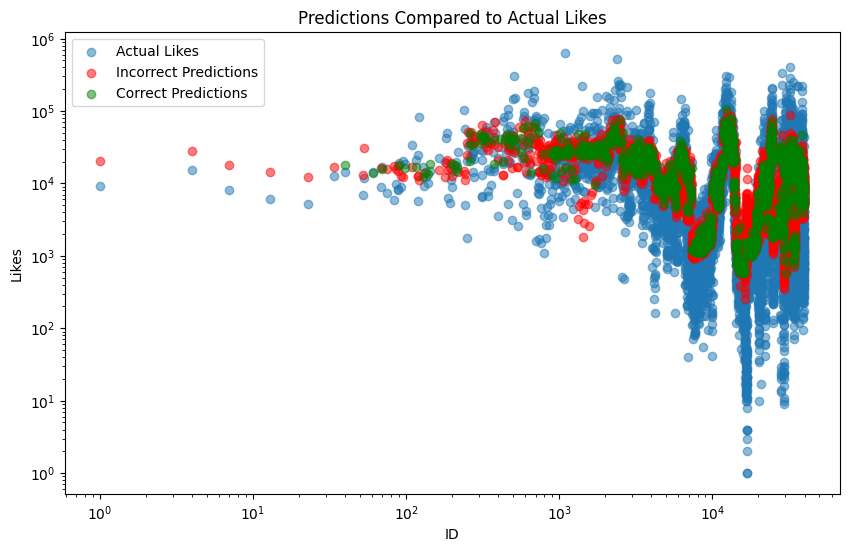

In [132]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_scaled_indices, sorted_scaled_likes, label='Actual Likes', alpha=0.5)
plt.scatter(sorted_incorrect_scaled_likes_pred_indices, sorted_incorrect_scaled_likes_pred, label='Incorrect Predictions', color='red', alpha=0.5)
plt.scatter(sorted_correct_scaled_likes_pred_indices, sorted_correct_scaled_likes_pred, label='Correct Predictions', color='green', alpha=0.5)
plt.xlabel('ID')
plt.ylabel('Likes')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Predictions Compared to Actual Likes')
plt.show()

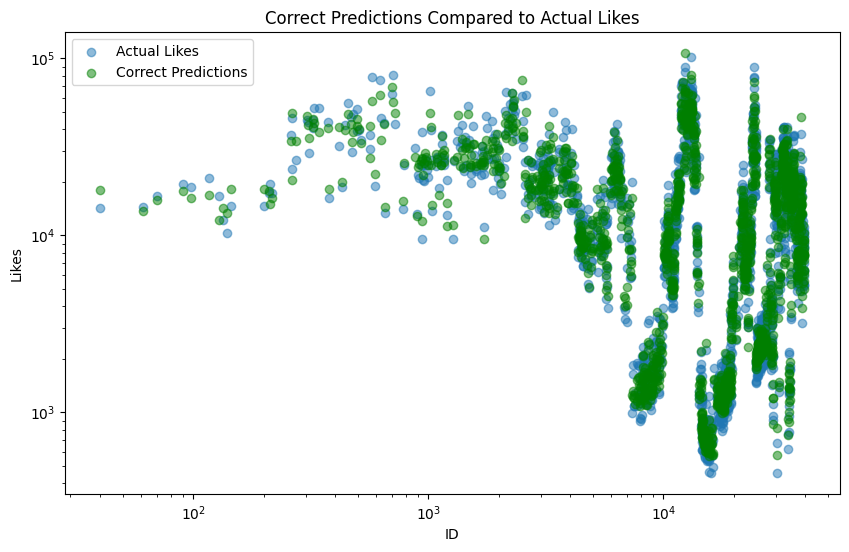

In [133]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_correct_scaled_indices, sorted_correct_scaled_likes, label='Actual Likes', alpha=0.5)
plt.scatter(sorted_correct_scaled_likes_pred_indices, sorted_correct_scaled_likes_pred, label='Correct Predictions', color='green', alpha=0.5)
plt.xlabel('ID')
plt.ylabel('Likes')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Correct Predictions Compared to Actual Likes')
plt.show()

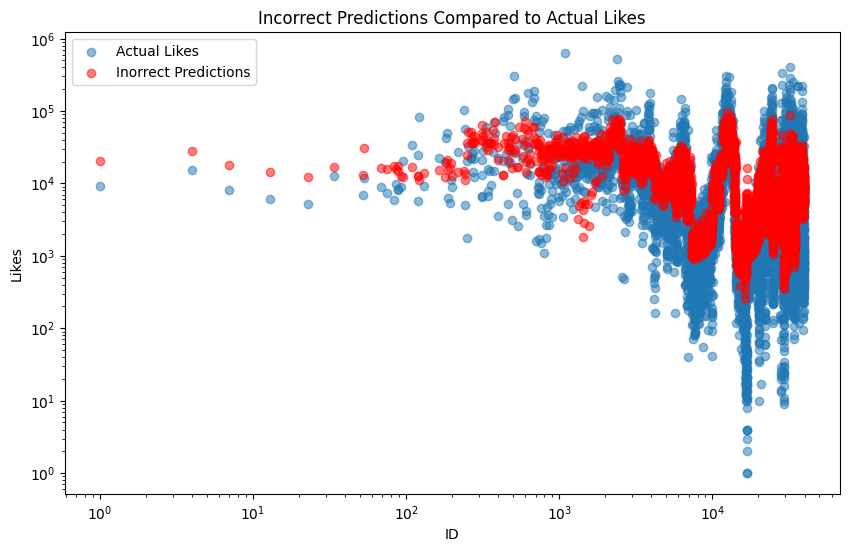

In [134]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_incorrect_scaled_indices, sorted_incorrect_scaled_likes, label='Actual Likes', alpha=0.5)
plt.scatter(sorted_incorrect_scaled_likes_pred_indices, sorted_incorrect_scaled_likes_pred, label='Inorrect Predictions', color='red', alpha=0.5)
plt.xlabel('ID')
plt.ylabel('Likes')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Incorrect Predictions Compared to Actual Likes')
plt.show()

Como podemos ver nos últimos dois plots, a tolerância garante que as predições corretas estejam perto e não apenas exatemente sobreposto ao views reais. Da mesma forma, as predições incorretas estão claramente desarmônicos com as views reais.

# Interpretando os modelos

Aqui vamos usar ferramentas para interpretar a influência dos features nos nossos modelos finais de views e likes

## Interpretando o modelo de views

Vamos plotar a importância de cada uma das features:

In [135]:
# Get feature importances from the model
feature_importances = rf_views_final.feature_importances_

In [136]:
# Define the lengths of each feature type
img_features_len = X_train_img_features.shape[1]
title_features_len = X_train_title_features.shape[1]
tags_features_len = X_train_tags_features.shape[1]
subs_len = 1
views_len = 1
videos_len = 1
date_len = 1
one_hot_len = X_train_one_hot.shape[1]

In [137]:
# Get aggregated amounts
img_importance = np.mean(feature_importances[:img_features_len])
title_importance = np.mean(feature_importances[img_features_len:img_features_len + title_features_len])
tags_importance = np.mean(feature_importances[img_features_len + title_features_len:img_features_len + title_features_len + tags_features_len])

In [138]:
# Identify the indices for one-hot encoded day of the week and time of day features
day_of_week_indices = [i for i, col in enumerate(one_hot_columns) if 'Published Day of Week' in col]
time_of_day_indices = [i for i, col in enumerate(one_hot_columns) if 'Published Time of Day' in col]

# Get aggregated amounts
day_of_week_importance = np.mean([feature_importances[img_features_len + title_features_len + tags_features_len + 5 + i] for i in day_of_week_indices])
time_of_day_importance = np.mean([feature_importances[img_features_len + title_features_len + tags_features_len + 5 + i] for i in time_of_day_indices])

In [139]:
# Create a new DataFrame for the aggregated feature importances
aggregated_importances = {
    'img_features': img_importance,
    'title_features': title_importance,
    'tags_features': tags_importance,
    'subscriber_count': feature_importances[img_features_len + title_features_len + tags_features_len],
    'total_views': feature_importances[img_features_len + title_features_len + tags_features_len + 1],
    'num_videos': feature_importances[img_features_len + title_features_len + tags_features_len + 2],
    'date_posted': feature_importances[img_features_len + title_features_len + tags_features_len + 3],
    'duration_seconds': feature_importances[img_features_len + title_features_len + tags_features_len + 4],
    'day_of_week_features': day_of_week_importance,
    'time_of_day_features': time_of_day_importance,
}

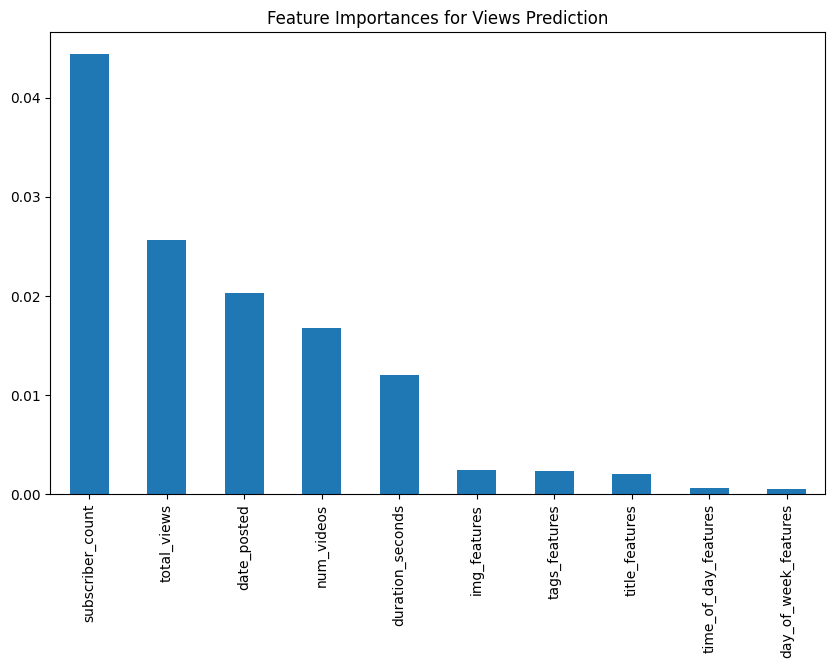

In [140]:
# Convert to a pandas Series
importances = pd.Series(aggregated_importances)
# Sort and plot feature importances
importances = importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importances for Views Prediction')
plt.show()

- Como podemos ver acima a relevância do canal é um fator determinante para o desempenho de um vídeo. Isso é claro pela importância que o número de inscritos e número de views totais de um canal têm em relação às outras features. 

- Além disso, a data do vídeo influencia também, pois vídeos mais antigos tendem a ter mais views (pois tiveram mais chances de serem assistidos).

- Veja que a imagem e título também influenciam o desempenho do vídeo, mas por outro lado, o dia ou hora da semana em que um vídeo é postado tem quase nenhuma importância para o modelo. Nos primeiros dias em que um vídeo é postado isso pode até fazer alguma diferença. Por exemplo, se um vídeo é postado na sexta ele tende a ter um desempenho melhor no primeiro momento pois as pessoas terão o final de semana desocupados para assistir o vídeo. Por outro laod, o vídeo postado numa segunda tende a ter um desempenho pior no primeiro momento pois as pessoas possuem menos tempo livre para assistir o vídeo. Contudo, à medida que o tempo passa, isso vai se diluindo com os novos viewers até fazer com que o dia que o vídeo foi postado não tenha pouquíssima relevância.

## Interpretando o modelo de likes

Vamos plotar a importância de cada uma das features:

In [141]:
# Get feature importances from the model
feature_importances = rf_likes_final.feature_importances_

In [142]:
# Get aggregated amounts
img_importance = np.mean(feature_importances[:img_features_len])
title_importance = np.mean(feature_importances[img_features_len:img_features_len + title_features_len])
tags_importance = np.mean(feature_importances[img_features_len + title_features_len:img_features_len + title_features_len + tags_features_len])

In [143]:
# Identify the indices for one-hot encoded day of the week and time of day features
day_of_week_indices = [i for i, col in enumerate(one_hot_columns) if 'Published Day of Week' in col]
time_of_day_indices = [i for i, col in enumerate(one_hot_columns) if 'Published Time of Day' in col]

# Get aggregated amounts
day_of_week_importance = np.mean([feature_importances[img_features_len + title_features_len + tags_features_len + 5 + i] for i in day_of_week_indices])
time_of_day_importance = np.mean([feature_importances[img_features_len + title_features_len + tags_features_len + 5 + i] for i in time_of_day_indices])

In [144]:
# Create a new DataFrame for the aggregated feature importances
aggregated_importances = {
    'img_features': img_importance,
    'title_features': title_importance,
    'tags_features': tags_importance,
    'subscriber_count': feature_importances[img_features_len + title_features_len + tags_features_len],
    'total_views': feature_importances[img_features_len + title_features_len + tags_features_len + 1],
    'num_videos': feature_importances[img_features_len + title_features_len + tags_features_len + 2],
    'date_posted': feature_importances[img_features_len + title_features_len + tags_features_len + 3],
    'duration_seconds': feature_importances[img_features_len + title_features_len + tags_features_len + 4],
    'day_of_week_features': day_of_week_importance,
    'time_of_day_features': time_of_day_importance,
}

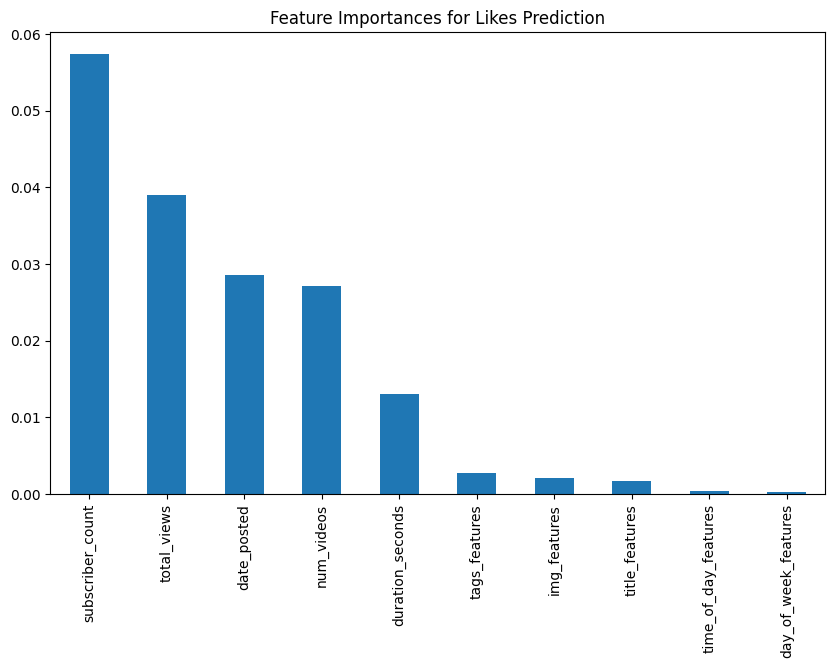

In [145]:
# Convert to a pandas Series
importances = pd.Series(aggregated_importances)
# Sort and plot feature importances
importances = importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importances for Likes Prediction')
plt.show()

Devido a correlação alta entre número de views e número de likes, temos resultados quase idêntico para a importância das features do modelo de views. Assim, não reiteraremos os mesmos motivadores de importância das features.

Por curiosidade, implementamos o mesmo modelo, porém com uma rede neural no final ao invés dos dois random forests. Por brevidade, não colocaremos o código aqui, porém os resultados no plot mostram um fenômeno muito parecido com o que vimos com o modelo de random forests que exploramos aqui nesse projeto: falta de dados. 

Contudo por usar uma rede neural, mostrou-se a divergência típica de overfitting entre o erro de treino e teste. Isso mostra como o modelo de random forest é mais capaz de generalizar.

# Conclusão

Em suma, nesse trabalho: 

- Exploramos se seria possível prever o número de likes e views de um vídeo de Youtube usando apenas informações disponíveis antes de postá-lo.

- Usamos a API do Youtube para coletar quase 40k dados. Cada um destes continha imagem, título, número de inscritos do canal, duração do vídeo, data postada, entre outros.

- Inspirados no GPT-4o, implementamos um modelo multimodal que recebia como entrada imagens, corpos de texto e dados tabulares. Esse modelo era composto por:
    - Uma CNN para extrair features das imagens
    - Duas RNN para extrair features dos título e tags
    - Duas random forests para prever o número de likes e views

- Treinamos e testamos diferentes hyperparâmetros no nosso modelo usando 5-Fold Cross Validation

- Treinamos e testamos o melhor modelo do cross validation e obtivemos resultados pouco satisfatórios.

- Pudemos perceber a necessidade de termos mais dados para podermos usar esse modelo de modo mais efetivo. Se formos nos basear na nossa inspiração (o GPT-4o) isso se torna algo óbvio visto a complexidade das dados

- Tentamos entender melhor quais features foram mais importante para o modelo e porque eram mais relevantes.

Embora o desempenho do nosso modelo não tenha sido excepcional, este projeto proporcionou um profundo aprendizado sobre aprendizado de máquina, incluindo diferentes 'paradigmas' de learning, o uso de modelos multimodais e a importância da quantidade de dados. Ganhamos experiência prática em tuning de hiperparâmetros e cross validation, além de identificar as features mais relevantes para a previsão de likes e views no YouTube. Esse processo nos preparou melhor para futuros projetos, combinando diversas técnicas de forma mais eficaz e estratégica.